In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import matplotlib.gridspec as gridspec
from matplotlib import animation, rc
import matplotlib.colors as colors
from IPython.display import HTML
import collections
import seaborn as sns
from collections import OrderedDict
from sklearn.neighbors import KDTree, BallTree
from sklearn.metrics import pairwise
from pandas.tseries.offsets import MonthEnd
import shapefile
from shapely.geometry import shape, Point, Polygon
import scipy.stats as stats
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pysal
import scipy.stats
from matplotlib.colors import LogNorm
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import cartopy.feature as feature
from zipfile import ZipFile
from lxml import html
import xml.etree.ElementTree as et

In [2]:
output_path = '/Users/danielfisher/Dropbox/working_documents/papers/globalgasflaring/figures'

# DATA SETUP

In [3]:
hotspot_path_ats = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/processed/l3/all_sensors/all_flares_ats.csv'
hotspot_path_sls = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/processed/l3/all_sensors/all_flares_sls.csv'

ats_hotspot_df = pd.read_csv(hotspot_path_ats)
sls_hotspot_df = pd.read_csv(hotspot_path_sls)

ats_hotspot_df['sample_counts_flare'] = 1
sls_hotspot_df['sample_counts_flare'] = 1

In [4]:
sampling_path_ats = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/processed/l3/all_sensors/all_sampling_ats.csv'
sampling_path_sls = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/processed/l3/all_sensors/all_sampling_sls.csv'

ats_hotspot_sampling_df = pd.read_csv(sampling_path_ats)
sls_hotspot_sampling_df = pd.read_csv(sampling_path_sls)

ats_hotspot_sampling_df['sample_counts_all'] = 1
sls_hotspot_sampling_df['sample_counts_all'] = 1

In [5]:
volc_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/volcanoes/volcanoes.csv'
volc_df = pd.read_csv(volc_path)
volc_df.dropna(inplace=True)

In [6]:
def extract_countries():
    c_shp = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/borders/EEZ_land_union_v2_201410/EEZ_land_v2_201410.shp'
    shape_file = shapefile.Reader(c_shp)
    #first feature of the shapefile
    countries = {}
    for feature in shape_file.shapeRecords():
        country_name = feature.record[2]
        country_shp = shape(feature.shape.__geo_interface__)
        #eez_boundaries[eez_name] = eez_shp.simplify(0.2) 
        countries[country_name] = country_shp
    return countries
    
    
def create_countries_dataframe(countries, df):
    cols = ['lats_arcmin', 'lons_arcmin', 'lats', 'lons']
    countries_df = df.drop_duplicates(['lats_arcmin', 'lons_arcmin'])[cols].copy()
    country_list = []
    for i, row in countries_df.iterrows():
        country_found = False
        point = Point(row.lons,row.lats)    
        for k in countries:
            poly = countries[k]
            if point.within(poly):
                country_list.append(k)
                country_found = True
                break
        if country_found:
            continue    
        # if we are here no countries have been found so
        country_list.append('Without Country')  
    countries_df['countries'] = country_list
    return countries_df
    
countries_dict = extract_countries()
ats_countries_df = create_countries_dataframe(countries_dict, ats_hotspot_df)
sls_countries_df = create_countries_dataframe(countries_dict, sls_hotspot_df)

In [7]:
bcm_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/dmsp/BCM_Global_20110223.xlsx'
cols=['Location', 'Year', 'MEAN BCM']
bcm_df_dict = pd.read_excel(bcm_path,  sheetname=None)
bcm_df = pd.concat(bcm_df_dict).reset_index()[['Year', 'Location', 'MEAN BCM']]
bcm_df.loc[bcm_df.Location=='Russia_Combined', 'Location'] = 'Russia'
bcm_df.loc[bcm_df.Location=='USA_Combined', 'Location'] = 'USA'
bcm_df.rename(columns={'Location': 'countries', 'Year': 'year', 'MEAN BCM': 'bcm'}, inplace=True)

In [8]:
viirs_flare_loc_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/NOAA_flare_locations/convertcsv.xlsx'
cols = ['longitude', 'latitude']
viirs_flare_loc_df = pd.read_excel(viirs_flare_loc_path,  sheetname='Sheet 1', usecols=cols)

In [9]:
viirs_iraq_hotspot_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/viirs_iraq_flares/hotspots.xlsx'
viirs_iraq_hotspot_df = pd.read_excel(viirs_iraq_hotspot_path)
viirs_iraq_hotspot_df.rename(columns={'lat': 'lats', 'lon': 'lons'}, inplace=True)

In [10]:
viirs_industrial_path = '/Users/danielfisher/Projects/kcl-globalgasflaring/data/external/viirs_industrial_sites'
kmz_fname = 'doc.kml'
doc = et.parse(os.path.join(viirs_industrial_path, kmz_fname))

In [134]:
nmsp = '{http://www.opengis.net/kml/2.2}'

df_list = []
for pm in doc.iterfind('.//{0}Placemark'.format(nmsp)):

    name = (pm.find('{0}name'.format(nmsp)).text)
    for ls in pm.iterfind('.//{0}coordinates'.format(nmsp)):
        pos = np.fromstring(ls.text.strip().replace('\n',''), dtype=float, sep=', ') 
        lon = pos[0]
        lat = pos[1]        
        df = pd.DataFrame([[lat,lon,name]], columns=['lats', 'lons', 'Name'])
        df_list.append(df)
        break
viirs_industrial_df = pd.concat(df_list)

# ------- DATA CLEANING -------

# The WHY (and notes at bottom!)

In [12]:
global_sampling = sls_hotspot_sampling_df.groupby(['year', 'sensor'], as_index=False).agg({'sample_counts_all': np.sum,
                                                                              'cloud_cover': np.mean})
global_sampling

,year,sensor,sample_counts_all,cloud_cover
0,2016.0,sls,83,0.378067
1,2017.0,sls,5786942,0.495266
2,2018.0,sls,842409,0.431191


In [13]:
# get the global annual FRP values
global_sampling = ats_hotspot_sampling_df.groupby(['year', 'sensor'], as_index=False).agg({'sample_counts_all': np.sum,
                                                                              'cloud_cover': np.mean})
global_sampling

,year,sensor,sample_counts_all,cloud_cover
0,1991.0,at1,724881,0.557577
1,1992.0,at1,1820896,0.461199
2,1993.0,at1,1978863,0.370619
3,1994.0,at1,1989056,0.335980
4,1995.0,at1,1916925,0.376087
5,1995.0,at2,1210624,0.588455
6,1996.0,at1,909591,0.408362
7,1996.0,at2,1144766,0.589764
8,1997.0,at2,2270963,0.591663
9,1998.0,at2,2216261,0.590900


Turn the below into a table and use to state why we are doing certain things (e.g. which data is being exlcuded and why we use AT2 and ATS cloud flags for AT1 when available)

# UPDATE AT1 flare cloud % (with an annual mean for each flare) here

In [14]:
def update_at1_cloud_cover(ats_sampling_df):
    not_at1_sampling = ats_sampling_df[ats_sampling_df.sensor !='at1'].copy()
    not_at1_sampling_mean_cc = not_at1_sampling.groupby(['lats_arcmin', 'lons_arcmin'], as_index=False).agg({'cloud_cover':np.mean})
    not_at1_sampling_mean_cc['sensor'] = 'at1'
    not_at1_sampling_mean_cc.rename(columns={'cloud_cover':'updated_cloud_cover'}, inplace=True)
    ats_sampling_df = ats_sampling_df.merge(not_at1_sampling_mean_cc, on=['lats_arcmin', 'lons_arcmin', 'sensor'], how='outer')
    print np.sum((ats_sampling_df.sensor=='at1') & (~ats_sampling_df.updated_cloud_cover.notnull()))
    
    mask = ats_sampling_df.updated_cloud_cover.notnull()
    ats_sampling_df.cloud_cover.loc[mask] = ats_sampling_df.updated_cloud_cover.loc[mask]
    ats_sampling_df.drop('updated_cloud_cover', axis=1, inplace=True)
    return ats_sampling_df

In [15]:
ats_hotspot_sampling_df = update_at1_cloud_cover(ats_hotspot_sampling_df)

0


/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
# get the global annual FRP values
global_sampling = ats_hotspot_sampling_df.groupby(['year', 'sensor'], as_index=False).agg({'sample_counts_all': np.sum,
                                                                              'cloud_cover': np.mean})
global_sampling

,year,sensor,sample_counts_all,cloud_cover
0,1991.0,at1,724881,0.594955
1,1992.0,at1,1820896,0.592654
2,1993.0,at1,1978863,0.592121
3,1994.0,at1,1989056,0.593481
4,1995.0,at1,1916925,0.591370
5,1995.0,at2,1210624,0.588455
6,1996.0,at1,909591,0.595259
7,1996.0,at2,1144766,0.589764
8,1997.0,at2,2270963,0.591663
9,1998.0,at2,2216261,0.590900


In [ ]:
# Update SLS

# Drop dodgy data from FRP dataframe (see Notes at bottom)

In [17]:
# remove all 1995 AT2 data (just rely on that from AT1)
# AT1 data to May 1996 (scan mirror failure on AT2)
# AT2 data from JUl 1996

mask = (~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1995)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2003)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 1)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 2)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 3)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 4)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 5)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 7)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 8)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 9)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 10)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 11)) &
        ~((ats_hotspot_df.sensor == 'at1' ) & (ats_hotspot_df.year == 1996) & (ats_hotspot_df.month == 12)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 4)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 5)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 6)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 7)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 8)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 9)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 10)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 11)) &
        ~((ats_hotspot_df.sensor == 'at2' ) & (ats_hotspot_df.year == 2002) & (ats_hotspot_df.month == 12))        
       )

ats_hotspot_df = ats_hotspot_df[mask]

In [18]:
# ALSO Drop from sampling

In [19]:
mask = (~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1995)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2003)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 1)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 2)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 3)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 4)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 5)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 7)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 8)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 9)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 10)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 11)) &
        ~((ats_hotspot_sampling_df.sensor == 'at1' ) & (ats_hotspot_sampling_df.year == 1996) & (ats_hotspot_sampling_df.month == 12)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 4)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 5)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 6)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 7)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 8)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 9)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 10)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 11)) &
        ~((ats_hotspot_sampling_df.sensor == 'at2' ) & (ats_hotspot_sampling_df.year == 2002) & (ats_hotspot_sampling_df.month == 12))        
       )

ats_hotspot_sampling_df = ats_hotspot_sampling_df[mask]


## RATIO THRESHOLD 

/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in divide
  # This is added back by InteractiveShellApp.init_path()
/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in divide


MWIR ratio 1400K 1.61698268645
MWIR ratio 2800K 8.34675318512
SWIR ratio 1400K 0.844738420688
SWIR ratio 2800K 1.92537559432


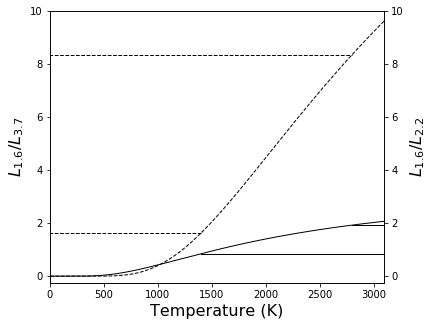

In [20]:
plt.close('all')

def planck_radiance(wvl, temp):
    '''
    wvl: wavelngth (microns)
    temp: temperature (kelvin)
    '''
    c1 = 1.19e-16  # W m-2 sr-1
    c2 = 1.44e-2  # mK
    wt = (wvl*1.e-6) * temp # m K
    d = (wvl*1.e-6)**5 * (np.exp(c2/wt)-1)
    return c1 / d * 1.e-6  # W m-2 sr-1 um-1

flare_size = 10000  # in sq. m.
pixel_size = 1e6  # in sq. m.
flare_area_pc = flare_size / pixel_size  # unitless

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
ax1 = ax0.twinx()

temps = np.arange(0,3501, 1)  # in K


spect_rad_swir = flare_area_pc * planck_radiance(1.6, temps)
spect_rad_swir_2 = flare_area_pc * planck_radiance(2.2, temps)
spect_rad_mwir = flare_area_pc * planck_radiance(3.7, temps)
spect_rad_lwir = flare_area_pc * planck_radiance(11, temps)


ratio_mwir = spect_rad_swir / spect_rad_mwir
ratio_swir = spect_rad_swir / spect_rad_swir_2

print 'MWIR ratio 1400K', ratio_mwir[1400]
print 'MWIR ratio 2800K', ratio_mwir[2800]
print 'SWIR ratio 1400K', ratio_swir[1400]
print 'SWIR ratio 2800K', ratio_swir[2800]


ax0.plot(temps, ratio_mwir,  "k--", linewidth=1)
#ax0.plot([1400,1400],[-5, ratio_mwir[1400]],'k--',linewidth=0.25)
#ax0.plot([2800,2800],[-5, ratio_mwir[2800]],'k--',linewidth=0.25)
ax0.plot([-1,1400],[ratio_mwir[1400], ratio_mwir[1400]],'k--',linewidth=1)
ax0.plot([-1,2800],[ratio_mwir[2800], ratio_mwir[2800]],'k--',linewidth=1)


ax0.set_ylim([-0.25,10])
ax0.set_xlim([-0.25,3100])


ax0.plot(temps, ratio_swir,  "k-", linewidth=1)
#ax0.plot([1400,1400],[-5, ratio_swir[1400]],'k-',linewidth=0.25)
#ax0.plot([2800,2800],[-5, ratio_swir[2800]],'k-',linewidth=0.25)
ax0.plot([1400,3501],[ratio_swir[1400], ratio_swir[1400]],'k-',linewidth=1)
ax0.plot([2800, 3501],[ratio_swir[2800], ratio_swir[2800]],'k-',linewidth=1)

ax1.set_ylim([-0.25,10])
ax1.set_xlim([-0.25,3100])


ax0.set_xlabel("Temperature (K)", fontsize=16)
ax0.set_ylabel("$L_{1.6} / L_{3.7}$", fontsize=16)
ax1.set_ylabel("$L_{1.6} / L_{2.2}$", fontsize=16)
plt.savefig(os.path.join(output_path, 'ratio_plot.png'), bbox_inches='tight', dpi=600)
plt.show()


# FLARE DETECTION

The first stage in the process is to refine the persistent hotspots down to actual gas flares.  This is done by removing hotspots associated with volcanism and those associated with industrial activity rather than flaring.  Some erroneous hotspots are left behind, e.g. with the SAA, but they will likely have little impact on the final analysis result.  This is one of the benefits of using the FRE measure inplace of flare counts.

In [21]:
ats_hotspot_df_subset = ats_hotspot_df[['lons_arcmin', 'lats_arcmin', 'lats', 'lons', 'sample_counts_flare']].copy()
to_group = ['lats_arcmin', 'lons_arcmin']
to_agg = {'lats': np.mean,
          'lons': np.mean,
          'sample_counts_flare': np.sum}
ats_hotspot_df_subset = ats_hotspot_df_subset.groupby(to_group, as_index=False).agg(to_agg)

In [22]:
sls_hotspot_df_subset = sls_hotspot_df[['lons_arcmin', 'lats_arcmin', 'lats', 'lons', 'sample_counts_flare']].copy()
to_group = ['lats_arcmin', 'lons_arcmin']
to_agg = {'lats': np.mean,
          'lons': np.mean,
          'sample_counts_flare': np.sum}
sls_hotspot_df_subset = sls_hotspot_df_subset.groupby(to_group, as_index=False).agg(to_agg)

## ATS Ratio

In [23]:
ats_ratio_df = ats_hotspot_df[['mwir_bg', 'sensor', 'swir_radiances', 'mwir_radiances',
                             'lats_arcmin', 'lons_arcmin']].copy()

ats_ratio_df.mwir_bg.loc[ats_ratio_df.mwir_bg == -1] = np.nan  # invalid background
ats_ratio_df.mwir_bg.loc[ats_ratio_df.sensor == 'at1'] = np.nan  # no MWIR from AT1

eps= 0.001
ratio = ats_ratio_df.swir_radiances.values / \
        ((ats_ratio_df.mwir_radiances.values - ats_ratio_df.mwir_bg.values)+ eps)
ats_ratio_df['ratio'] = ratio

# here we are assuming that any sautrated MWIR pixel is a flare.  This is likely not the case, 
# as perhaps some SAA or wildfire will lead saturated MWIR radiances.  However, a lot of large gas flares
# will also saturate the MWIR, so we can just assume that they are all gas flares 
saturated_mask = np.isnan(ats_ratio_df.mwir_radiances.values)  
ats_ratio_df.ratio.loc[saturated_mask] = 5

to_group = ['lats_arcmin', 'lons_arcmin']
to_agg = {'ratio': np.nanmedian}  # take the median of the non null values, use median as less affected by noise.
ats_ratio_df = ats_ratio_df.groupby(to_group, as_index=False).agg(to_agg)

ats_ratio_df['is_flare'] = (ats_ratio_df.ratio >= 1.6) & (ats_ratio_df.ratio < 8.34)

/Users/danielfisher/anaconda2/envs/kcl-globalgasflaring/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:612: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [24]:
ats_ratio_df.describe()

,lats_arcmin,lons_arcmin,ratio
count,26942.000000,26942.000000,25031.000000
mean,2919.510541,3564.467523,5.931195
std,2609.319661,6125.219649,183.885475
min,-7731.000000,-17505.000000,-5490.287241
25%,1347.500000,640.000000,2.550014
50%,3115.000000,4915.000000,3.882701
75%,4915.000000,7641.000000,5.000000
max,8056.000000,17728.000000,20783.377335


## SLS Ratio

In [25]:
sls_ratio_df = sls_hotspot_df[['sensor', 'swir_radiances', 'swir_radiances_22',
                       'lats_arcmin', 'lons_arcmin']].copy()

eps= 0.001
ratio = sls_ratio_df.swir_radiances.values / (sls_ratio_df.swir_radiances_22 + eps)
sls_ratio_df['ratio'] = ratio

# here taking the mean behaviour of the gas flare over all its samples.
# This is where something is going wrong with the SLSTR behaviour.
# so maybe we have some bad data in here somewhere.
to_group = ['lats_arcmin', 'lons_arcmin']
to_agg = {'ratio': np.nanmedian}  # take the mean of the non null values
sls_ratio_df = sls_ratio_df.groupby(to_group, as_index=False).agg(to_agg)

# inser flare variable
sls_ratio_df['is_flare'] = (sls_ratio_df.ratio >= 0.85) & (sls_ratio_df.ratio < 1.92)

In [26]:
sls_ratio_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25589 entries, 0 to 25588
Data columns (total 4 columns):
lats_arcmin    25589 non-null int64
lons_arcmin    25589 non-null int64
ratio          25589 non-null float64
is_flare       25589 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 824.6 KB


## Reassign AT1 Null Flares based on ratio

In [27]:
def reassign_flares(ratio_df, location_df, k=101, d=1):
    '''
    k = number of neighbors to consider
    d = max distance to consider for neighbours
    '''
    current_flares = ratio_df.is_flare.values

    flare_locations = np.array(zip(np.deg2rad(location_df.lats.values), 
                                   np.deg2rad(location_df.lons.values)))

    # compare the flare locations to the potential locations in the orbit
    locations_balltree = BallTree(flare_locations, metric='haversine')
    distances, indexes = locations_balltree.query(flare_locations, k=k) 

    # distances mask
    self_mask = np.rad2deg(distances) > 1/60  # do not consider the point itself
    masked_distances = (np.rad2deg(distances) < d) & self_mask # and not pionts > 1 deg away

    # update is flare based on neighbours
    is_flare = np.ones(ratio_df.ratio.shape)*999
    for i in xrange(is_flare.size):

        # get the ratio of the set of flares a closest to current flare 
        closest_flares = ratio_df.is_flare[indexes[i,:]] 

        # mask based on distances
        masked_closest = closest_flares[masked_distances[i, :]]
        if len(masked_closest) > 0:

            # take the nanmean of valid values.  We will have nans nearby
            # due to invalid backgrounds and observations from AT1
            mean_local_type = np.nanmean(masked_closest)

            # if mean is > 0.5, then majority is flare, else majority is industrial
            if mean_local_type >= 0.5:
                is_flare[i] = 1
            else:
                is_flare[i] = 0
        else:
            is_flare[i] = current_flares[i]
    
    # get the null ratio mask
    ratio_df['updated_flare'] = is_flare
    return ratio_df

In [28]:
ats_ratio_df = reassign_flares(ats_ratio_df, ats_hotspot_df_subset)
sls_ratio_df = reassign_flares(sls_ratio_df, sls_hotspot_df_subset)

In [29]:
mask = ats_ratio_df.ratio.isnull()
ats_ratio_df.is_flare.loc[mask] = ats_ratio_df.updated_flare.loc[mask]

## Find distances from known Volcanoes to Hotspots

In [30]:
def dist_to_nearest_volcano(volc_df, location_df):
    
    volc_lat_lon = np.dstack([np.deg2rad(volc_df.Latitude.values), 
                              np.deg2rad(volc_df.Longitude.values)])[0]
    volc_balltree = BallTree(volc_lat_lon, metric='haversine')

    # get the unique flare lats and lons for assessment in kdtree
    flare_locations = np.array(zip(np.deg2rad(location_df.lats.values), 
                                   np.deg2rad(location_df.lons.values)))

    # compare the flare locations to the potential locations in the orbit
    distances, indexes = volc_balltree.query(flare_locations, k=1) 

    # set up the dataframe to hold the distances
    location_df['distance_to_a_volcano'] = np.rad2deg(distances)
    return location_df

In [31]:
ats_hotspot_df_subset = dist_to_nearest_volcano(volc_df, ats_hotspot_df_subset)
sls_hotspot_df_subset = dist_to_nearest_volcano(volc_df, sls_hotspot_df_subset)

## Merge ratio and distance to volcano dataframes

In [32]:
ats_hotspot_df_subset = ats_hotspot_df_subset.merge(ats_ratio_df,  on=['lats_arcmin', 'lons_arcmin'])
sls_hotspot_df_subset = sls_hotspot_df_subset.merge(sls_ratio_df,  on=['lats_arcmin', 'lons_arcmin'])

## Masking

In [52]:
def mask_non_flare_hotspots(df):
    s1 = df.shape[0]
    volcanic_hotspot_df = df[df.distance_to_a_volcano < 5.0/60]
    df = df[df.distance_to_a_volcano > 5.0/60]  # must be ~10km from any volcano 
    s2 = df.shape[0]
    print 'Hotspots removed due to proximity to volcano:', s2-s1
    
    # remove hotspots associated with industrial activity other than flaring
    s1 = df.shape[0]
    bad_ratio_df = df[(df.is_flare == 0)] 
    good_ratio_df = df[(df.is_flare == 1)] 
    df = df[(df.is_flare == 1)] 
    s2 = df.shape[0]
    print 'Hotspots removed due to non flaring activity', s2-s1
    
    return df, volcanic_hotspot_df, bad_ratio_df, good_ratio_df

ats_screened_hotspot_df, ats_volc_df, ats_bad_ratio_df, ats_good_ratio_df = mask_non_flare_hotspots(ats_hotspot_df_subset)
sls_screened_hotspot_df, sls_volc_df, sls_bad_ratio_df, sls_good_ratio_df = mask_non_flare_hotspots(sls_hotspot_df_subset)


Hotspots removed due to proximity to volcano: -296
Hotspots removed due to non flaring activity -5178
Hotspots removed due to proximity to volcano: -285
Hotspots removed due to non flaring activity -7467


## Check rario at Volcanic Hotspots as an indicator

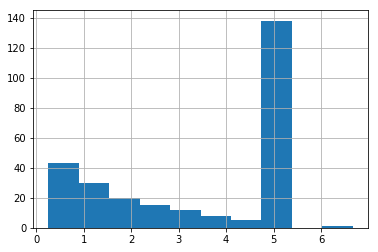

In [35]:
ats_volc_df.ratio.hist()
plt.show()

## Thermal Anomaly Plotting

In [36]:
def plot_data_screening(flare_df, volc_df, ratio_df, lab, fname):
    
    plt.close('all')
    fig = plt.figure(figsize=(15,10))
    ax_list = []
    ax_list.append(plt.subplot2grid((4, 5), (0, 0), colspan=5, rowspan=3, projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 0), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 1), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 2), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 3), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 4), projection=ccrs.PlateCarree()))
    
    for ax in ax_list:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # set limites
    xlims = [(-180, 180), (-105, -87), (4, 9), (46, 56), (65, 82), (106, 125)]
    ylims = [(-90, 90), (25, 39), (3, 7), (23, 33), (55, 68), (33, 45)]
    pos = [(-102, 40), (-2, -1), (39, 26), (83, 62), (113, 47)]
    for ax, xlim, ylim in zip(ax_list, xlims, ylims):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.coastlines()
        
    # scale the values
    flare_counts = flare_df['sample_counts_flare']     
    ind_counts = ratio_df['sample_counts_flare']
    
    # make main plot
    ax_list[0].text(0.94, 0.92, lab, transform=ax_list[0].transAxes, fontsize=25)
    ax_list[0].plot(volc_df.lons, volc_df.lats, '.', color='gray', markersize=10, label='Volcanic')
    scat = ax_list[0].scatter(flare_df.lons, flare_df.lats,
                      s=flare_counts/10, lw=0.2, 
                      edgecolors='r',
                      facecolor='None',
                      label = 'Flare')
    scat = ax_list[0].scatter(ratio_df.lons, ratio_df.lats,
                      s=ind_counts/10, lw=0.2, 
                      edgecolors='b',
                      facecolor='None',
                      label = "Non-Flare")
    leg0 = ax_list[0].legend(loc = 2, scatterpoints = 1, prop={'size': 13})
    leg0.legendHandles[0]._sizes = [100]
    leg0.legendHandles[1]._sizes = [100]
    leg0.legendHandles[2]._sizes = [100]
    leg0.get_frame().set_alpha(1)
    
    l1 = ax_list[0].scatter([-170],[-70], s=10/10, edgecolors='k', facecolor='None')
    l2 = ax_list[0].scatter([-170],[-70], s=100/10, edgecolors='k', facecolor='None')
    l3 = ax_list[0].scatter([-170],[-70], s=500/10, edgecolors='k', facecolor='None')
    l4 = ax_list[0].scatter([-170],[-70], s=1000/10, edgecolors='k', facecolor='None')

    labels = ["10", "100", "500", "1000"]
    leg1 = ax_list[0].legend([l1, l2, l3, l4], labels, frameon=True, fontsize=14,
                     handlelength=2, loc = 3, borderpad = 1,
                     handletextpad=1, title='N. Samples', scatterpoints = 1, prop={'size': 15})
    leg1.get_frame().set_alpha(1)
    ax_list[0].add_artist(leg0)
    
    # add roi boxes
    for i, (p, x, y) in enumerate(zip(pos, xlims[1:], ylims[1:])):
        ax_list[0].plot([x[0], x[0], x[1], x[1], x[0]], 
                        [y[0], y[1], y[1], y[0], y[0]], 'k-')
        ax_list[0].text(p[0], p[1], str(i+1)+'.', fontsize=12)
        
        
    
    # make alt plots
    for i, ax in enumerate(ax_list[1:]):        
        scat = ax.scatter(flare_df.lons, flare_df.lats,
                          s=flare_counts/10, lw=0.2, 
                          edgecolors='r',
                          facecolor='None')
        scat = ax.scatter(ratio_df.lons, ratio_df.lats,
                          s=ind_counts/10, lw=0.2, 
                          edgecolors='b',
                          facecolor='None')
        ax.text(0.1, 0.1, str(i+1)+'.', transform=ax.transAxes, fontsize=15)
    
    plt.savefig(os.path.join(output_path, fname), bbox_inches='tight', dpi=600)
    plt.show()

No handlers could be found for logger "shapely.geos"


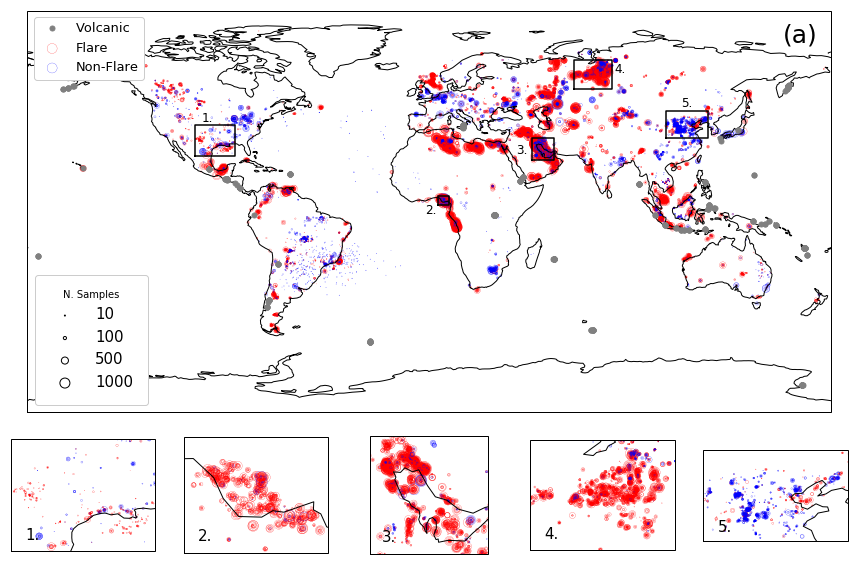

In [37]:
plot_data_screening(ats_good_ratio_df, ats_volc_df, ats_bad_ratio_df, '(a)', 'atsr_hotspots.png')

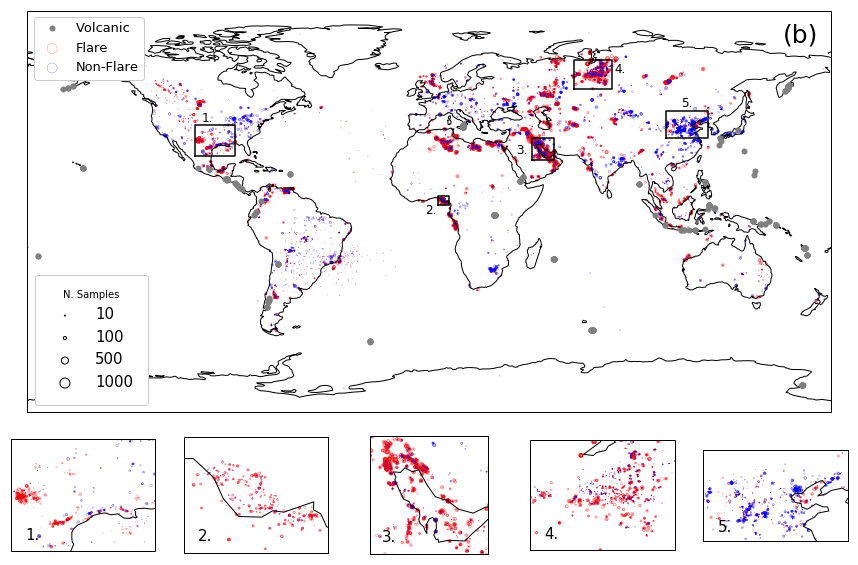

In [38]:
plot_data_screening(sls_good_ratio_df, sls_volc_df, sls_bad_ratio_df, '(b)', 'slstr_hotspots.png')

# REDUCE HOTSPOT DF TO FLARE DF

In [53]:
ats_flare_sampling_df = ats_hotspot_sampling_df.merge(ats_screened_hotspot_df[['lats', 'lons', 'lats_arcmin', 'lons_arcmin']], 
                                      on=['lats_arcmin', 'lons_arcmin'])
sls_flare_sampling_df = sls_hotspot_sampling_df.merge(sls_screened_hotspot_df[['lats', 'lons', 'lats_arcmin', 'lons_arcmin']], 
                                      on=['lats_arcmin', 'lons_arcmin'])

In [54]:
ats_screened_hotspot_df.drop(['sample_counts_flare', 'lats', 'lons'], axis=1, inplace=True)
ats_flare_df = ats_hotspot_df.merge(ats_screened_hotspot_df, on=['lats_arcmin', 'lons_arcmin'])

sls_screened_hotspot_df.drop(['sample_counts_flare', 'lats', 'lons'], axis=1, inplace=True)
sls_flare_df = sls_hotspot_df.merge(sls_screened_hotspot_df, on=['lats_arcmin', 'lons_arcmin'])

# STATISTICAL SCREENING

In [55]:
def make_stats_df(df):
    cols = ['lats_arcmin', 'lons_arcmin', 'lats', 'lons', 'frp', 'year', 'sample_counts_flare']
    stats_df = df[cols].copy()
    stats_df['frp_sd'] = stats_df['frp']
    stats_df['frp_mean'] = stats_df['frp']
    stats_df['frp_max'] = stats_df['frp']
    stats_df['frp_min'] = stats_df['frp']
    stats_df['frp_median'] = stats_df['frp']

    to_group = ['lats_arcmin', 'lons_arcmin']
    to_agg = {'frp_sd': np.std, 
              'frp_mean': np.mean, 
              'frp_min': np.min,
              'frp_max': np.max,
              'frp_median': np.median,
              'sample_counts_flare': np.sum,
             }
    stats_df = stats_df.groupby(to_group, as_index=False).agg(to_agg)
    return stats_df

In [56]:
ats_stats_df = make_stats_df(ats_flare_df)
ats_stats_df = ats_stats_df[ats_stats_df.sample_counts_flare > 6]
ats_flare_df = ats_flare_df.merge(ats_stats_df[['frp_mean', 'frp_sd', 'lats_arcmin', 'lons_arcmin']], on=['lats_arcmin', 'lons_arcmin'])
ats_flare_df = ats_flare_df[ats_flare_df.frp < ats_flare_df.frp_mean + 3*ats_flare_df.frp_sd]
ats_stats_df = make_stats_df(ats_flare_df)


In [57]:
sls_stats_df = make_stats_df(sls_flare_df)
sls_flare_df = sls_flare_df.merge(sls_stats_df[['frp_mean', 'frp_sd', 'lats_arcmin', 'lons_arcmin']], on=['lats_arcmin', 'lons_arcmin'])
sls_flare_df = sls_flare_df[sls_flare_df.frp < sls_flare_df.frp_mean + 3*sls_flare_df.frp_sd]
sls_stats_df = make_stats_df(sls_flare_df)


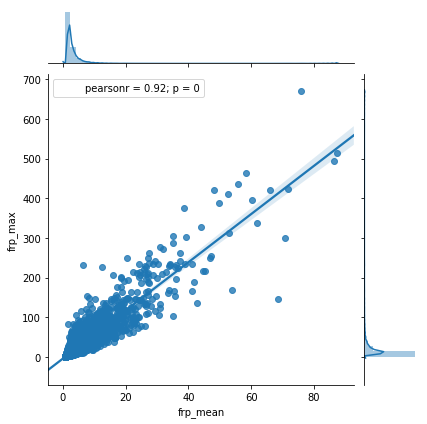

In [59]:
plt.close('all')
sns.jointplot(x=ats_stats_df.frp_mean, y=ats_stats_df.frp_max, data=ats_stats_df, kind='reg')
plt.show()

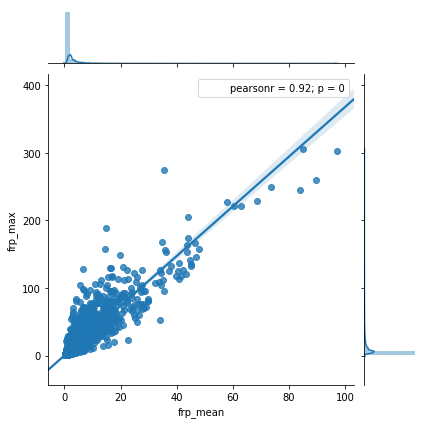

In [60]:
plt.close('all')
sns.jointplot(x=sls_stats_df.frp_mean, y=sls_stats_df.frp_max, data=sls_stats_df, kind='reg')
plt.show()

# ------- VIIRS COMPARISONS -------

# VIIRS Industrial Activity vs. ATX and SLS

In [97]:
def plot_location_comparison(atx_df, vir_df):
    
    plt.close('all')
    fig = plt.figure(figsize=(15,10))
    ax_list = []
    ax_list.append(plt.subplot2grid((4, 5), (0, 0), colspan=5, rowspan=3, projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 0), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 1), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 2), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 3), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 4), projection=ccrs.PlateCarree()))
    
    # set limits
    xlims = [(-180, 180), (-105, -87), (4, 9), (46, 56), (65, 82), (106, 125)]
    ylims = [(-90, 90), (25, 39), (3, 7), (23, 33), (55, 68), (33, 45)]
    pos = [(-102, 40), (-2, -1), (39, 26), (83, 62), (113, 47)]
    for ax, xlim, ylim in zip(ax_list, xlims, ylims):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.coastlines(color='white', linewidth=0.75)
        ax.imshow(np.tile(np.array([[[0,0,0]]], 
          dtype=np.uint8), [2, 2, 1]),
          origin='upper',
          transform=ccrs.PlateCarree(),
          extent=xlim+ylim)
        
    # make main plot
    #ax_list[0].text(0.94, 0.92, lab, transform=ax_list[0].transAxes, fontsize=25, color='w')
    ax_list[0].plot(vir_df.lons, vir_df.lats, 'o', color='cyan', markersize=1, alpha=0.3, label='VIIRS')
    ax_list[0].plot(atx_df.lons, atx_df.lats, 'o', color='magenta', markersize=1, alpha=0.3, label='AATSR')

    leg0 = ax_list[0].legend(loc = 2, scatterpoints = 1, prop={'size': 15,})
    leg0.get_frame().set_facecolor('k')
    for lh in leg0.legendHandles: 
        lh._legmarker.set_alpha(1)
    plt.setp(leg0.get_texts(), color='w')
    leg0.legendHandles[0]._sizes = [1500]
    leg0.legendHandles[1]._sizes = [1500]
    #leg0.legendHandles[2]._sizes = [1500]
    leg0.get_frame().set_alpha(1)
    ax_list[0].add_artist(leg0)
    
    # add roi boxes
    font = FontProperties()
    font.set_weight('bold')
    for i, (p, x, y) in enumerate(zip(pos, xlims[1:], ylims[1:])):
        ax_list[0].plot([x[0], x[0], x[1], x[1], x[0]], 
                        [y[0], y[1], y[1], y[0], y[0]], 'w-', linewidth=2)
        ax_list[0].text(p[0], p[1], str(i+1)+'.', fontproperties=font, fontsize=14, color='w')
          
    # make alt plots
    for i, ax in enumerate(ax_list[1:]):        
        ax.plot(vir_df.lons, vir_df.lats, 'o', color='cyan', markersize=1, alpha=0.3)
        ax.plot(atx_df.lons, atx_df.lats, 'o', color='magenta', markersize=1, alpha=0.3)
        ax.text(0.1, 0.1, str(i+1)+'.', transform=ax.transAxes, fontproperties=font, fontsize=15, color='w')

    #plt.savefig(os.path.join(output_path, 'viirs_vs_ats_detections.png'), bbox_inches='tight', dpi=600)
    plt.show()

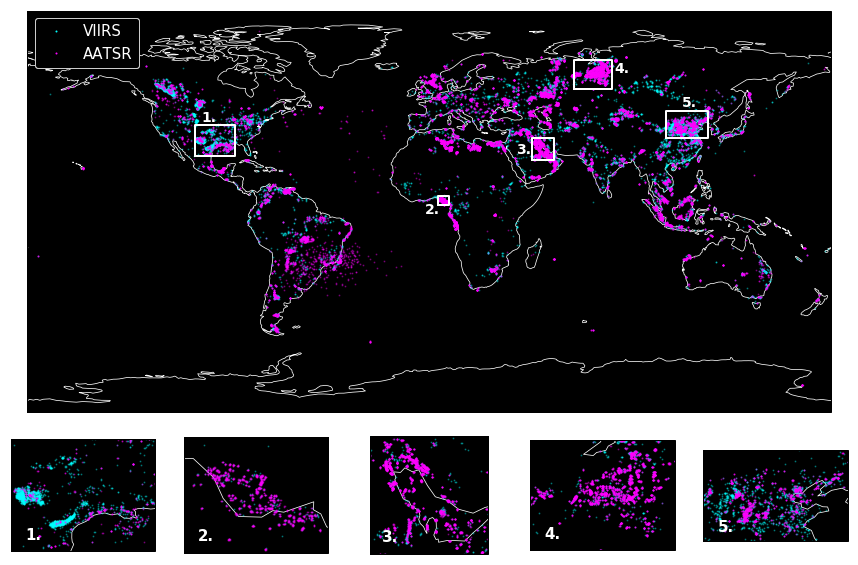

In [98]:
plot_location_comparison(ats_hotspot_df_subset, viirs_industrial_df)

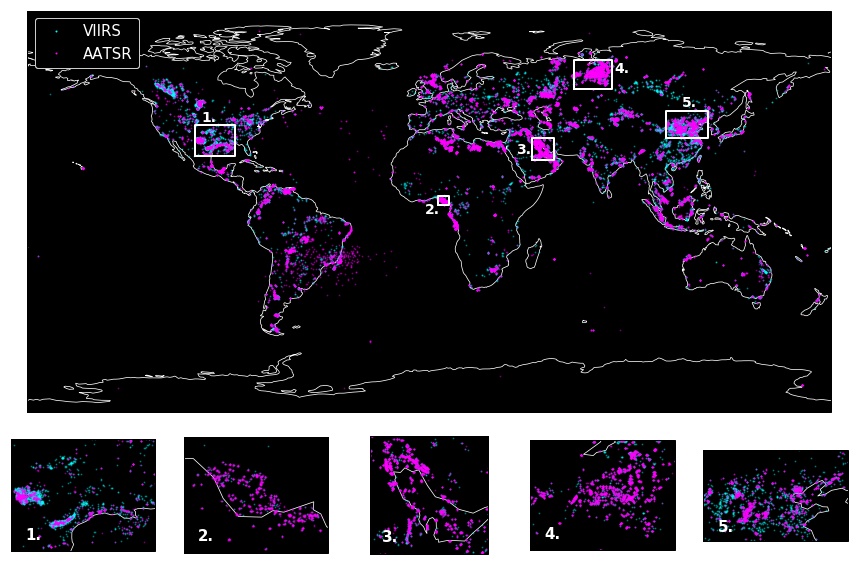

In [99]:
plot_location_comparison(sls_hotspot_df_subset, viirs_industrial_df)

In [135]:
def nearest_viirs_point(ats_df, viirs_df, k=1):
    '''
    k = number of neighbors to consider
    d = max distance to consider for neighbours
    '''
    ats_locations = np.array(zip(np.deg2rad(ats_df.lats.values), 
                                   np.deg2rad(ats_df.lons.values)))
    
    viirs_locations = np.array(zip(np.deg2rad(viirs_df.lats.values), 
                                   np.deg2rad(viirs_df.lons.values)))
    

    # compare the flare locations to the potential locations in the orbit
    locations_balltree = BallTree(ats_locations, metric='haversine')
    distances, indexes = locations_balltree.query(viirs_locations, k=k) 

    # get the nearest types
    is_flare = ats_df.is_flare.values[indexes.squeeze()]
    updated_flare = ats_df.updated_flare.values[indexes.squeeze()]
    ratio = ats_df.ratio.values[indexes.squeeze()]
    distances = np.rad2deg(distances)

    viirs_df['is_flare'] = is_flare
    viirs_df['updated_flare'] = updated_flare
    viirs_df['ratio'] = ratio
    viirs_df['distances'] = distances
    
    
    return viirs_df

In [136]:
id_dict = {'Nonmetal-mineral':1,
           'Ferrous-metal': 2,
           'Coal-processing': 3,
           'Oil/gas': 4
          }
viirs_industrial_df['name_id'] = viirs_industrial_df.Name.map(id_dict)

In [175]:
viirs_types_with_ats = nearest_viirs_point(ats_hotspot_df_subset, viirs_industrial_df.copy(), k=1)
viirs_types_with_sls = nearest_viirs_point(sls_hotspot_df_subset, viirs_industrial_df.copy(), k=1)

In [144]:
viirs_types_with_ats = viirs_types_with_ats[viirs_types_with_ats.distances < 0.1]
viirs_types_with_sls = viirs_types_with_sls[viirs_types_with_sls.distances < 0.1]

## Omission Comission Analysis 

In [168]:
print 'Omission: VIIRS sees flare, ATS does not'
mask = viirs_types_with_ats.name_id == 4

print 'VIIRS sees', np.sum(mask), 'flares'

is_flare_omission = 1 - (viirs_types_with_ats.is_flare.loc[mask].sum() / np.sum(mask))
updated_flare_omission = 1- (viirs_types_with_ats.updated_flare.loc[mask].sum() / np.sum(mask))
print 'is_flare_omission', is_flare_omission 
print 'updated_flare_omission', updated_flare_omission 


print
print 'Commision VIIRS does not see flare, ATS does'

mask_is_flare = viirs_types_with_ats.is_flare == 1
mask_updated_flare = viirs_types_with_ats.updated_flare == 1
print 'ATS ratio sees', np.sum(mask_is_flare), 'flares'
print 'ATS updated flag sees', np.sum(mask_updated_flare), 'flare'

is_flare_commission = 1 - (viirs_types_with_ats.name_id.loc[mask_is_flare] == 4).sum()*1. / np.sum(mask_is_flare)
updated_flare_commission = 1 - (viirs_types_with_ats.name_id.loc[mask_updated_flare] == 4).sum()*1. / np.sum(mask_updated_flare)


#updated_flare_omission = viirs_types_with_ats.updated_flare.loc[mask].sum() / np.sum(mask)
print 'is_flare_commission', is_flare_commission 
print 'updated_flare_commission', updated_flare_commission 


Omission: VIIRS sees flare, ATS does not
VIIRS sees 5217 flares
is_flare_omission 0.0753306497987
updated_flare_omission 0.0628713820203

Commision VIIRS does not see flare, ATS does
ATS ratio sees 5554 flares
ATS updated flag sees 5623 flare
is_flare_commission 0.131436802305
updated_flare_commission 0.130535301441


In [174]:
print 'Omission: VIIRS sees flare, SLS does not'
mask = viirs_types_with_sls.name_id == 4

print 'VIIRS sees', np.sum(mask), 'flares'

is_flare_omission = 1 - (viirs_types_with_sls.is_flare.loc[mask].sum() *1. / np.sum(mask))
updated_flare_omission = 1- (viirs_types_with_sls.updated_flare.loc[mask].sum() / np.sum(mask))
print 'is_flare_omission', is_flare_omission 
print 'updated_flare_omission', updated_flare_omission 


print
print 'Commision VIIRS does not see flare, SLS does'

mask_is_flare = viirs_types_with_sls.is_flare == 1
mask_updated_flare = viirs_types_with_sls.updated_flare == 1
print 'SLS ratio sees', np.sum(mask_is_flare), 'flares'
print 'SLS updated flag sees', np.sum(mask_updated_flare), 'flare'

is_flare_commission = 1 - (viirs_types_with_sls.name_id.loc[mask_is_flare] == 4).sum()*1. / np.sum(mask_is_flare)
updated_flare_commission = 1 - (viirs_types_with_sls.name_id.loc[mask_updated_flare] == 4).sum()*1. / np.sum(mask_updated_flare)


#updated_flare_omission = viirs_types_with_ats.updated_flare.loc[mask].sum() / np.sum(mask)
print 'is_flare_commission', is_flare_commission 
print 'updated_flare_commission', updated_flare_commission 

Omission: VIIRS sees flare, SLS does not
VIIRS sees 7045 flares
is_flare_omission 0.130731014904
updated_flare_omission 0.0452803406671

Commision VIIRS does not see flare, SLS does
SLS ratio sees 6989 flares
SLS updated flag sees 7623 flare
is_flare_commission 0.123765917871
updated_flare_commission 0.117670208579


In [171]:
viirs_types_with_sls.head()

,lats,lons,Name,name_id,is_flare,updated_flare,ratio,distances
0,-42.827084,-72.660418,Nonmetal-mineral,1,False,1.0,2.570876,0.009871
0,-40.522917,-72.143751,Nonmetal-mineral,1,True,0.0,1.717042,0.013084
0,-34.864584,-57.947918,Nonmetal-mineral,1,True,1.0,1.393812,0.012146
0,-32.577084,-60.785418,Nonmetal-mineral,1,False,0.0,0.292033,0.013786
0,-26.581250,27.968750,Nonmetal-mineral,1,True,0.0,1.871781,0.013207


# VIIRS FLARE LOCATION COMPARISON WITH AATSR

In [ ]:
def plot_location_comparison(both_df, vir_df, atx_df):
    
    plt.close('all')
    fig = plt.figure(figsize=(15,10))
    ax_list = []
    ax_list.append(plt.subplot2grid((4, 5), (0, 0), colspan=5, rowspan=3, projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 0), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 1), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 2), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 3), projection=ccrs.PlateCarree()))
    ax_list.append(plt.subplot2grid((4, 5), (3, 4), projection=ccrs.PlateCarree()))
    
    # set limits
    xlims = [(-180, 180), (-105, -87), (4, 9), (46, 56), (65, 82), (106, 125)]
    ylims = [(-90, 90), (25, 39), (3, 7), (23, 33), (55, 68), (33, 45)]
    pos = [(-102, 40), (-2, -1), (39, 26), (83, 62), (113, 47)]
    for ax, xlim, ylim in zip(ax_list, xlims, ylims):
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.coastlines(color='white', linewidth=0.75)
        ax.imshow(np.tile(np.array([[[0,0,0]]], 
          dtype=np.uint8), [2, 2, 1]),
          origin='upper',
          transform=ccrs.PlateCarree(),
          extent=xlim+ylim)
        
    # make main plot
    #ax_list[0].text(0.94, 0.92, lab, transform=ax_list[0].transAxes, fontsize=25, color='w')
    ax_list[0].plot(vir_df.longitude, vir_df.latitude, 'o', color='cyan', markersize=5, alpha=0.3, label='VIIRS')
    ax_list[0].plot(atx_df.longitude, atx_df.latitude, 'o', color='magenta', markersize=5, alpha=0.3, label='AATSR')
    ax_list[0].plot(both_df.longitude, both_df.latitude, 'o', color='yellow',markersize=5, alpha=0.3, label='Both')


    leg0 = ax_list[0].legend(loc = 2, scatterpoints = 1, prop={'size': 15,})
    leg0.get_frame().set_facecolor('k')
    for lh in leg0.legendHandles: 
        lh._legmarker.set_alpha(1)
    plt.setp(leg0.get_texts(), color='w')
    leg0.legendHandles[0]._sizes = [1500]
    leg0.legendHandles[1]._sizes = [1500]
    leg0.legendHandles[2]._sizes = [1500]
    leg0.get_frame().set_alpha(1)
    ax_list[0].add_artist(leg0)
    
    # add roi boxes
    font = FontProperties()
    font.set_weight('bold')
    for i, (p, x, y) in enumerate(zip(pos, xlims[1:], ylims[1:])):
        ax_list[0].plot([x[0], x[0], x[1], x[1], x[0]], 
                        [y[0], y[1], y[1], y[0], y[0]], 'w-', linewidth=2)
        ax_list[0].text(p[0], p[1], str(i+1)+'.', fontproperties=font, fontsize=14, color='w')
          
    # make alt plots
    for i, ax in enumerate(ax_list[1:]):        
        ax.plot(vir_df.longitude, vir_df.latitude, 'o', color='cyan', markersize=5, alpha=0.3)
        ax.plot(atx_df.longitude, atx_df.latitude, 'o', color='magenta', markersize=5, alpha=0.3)
        ax.plot(both_df.longitude, both_df.latitude, 'o', color='yellow', markersize=5, alpha=0.3)
        ax.text(0.1, 0.1, str(i+1)+'.', transform=ax.transAxes, fontproperties=font, fontsize=15, color='w')

    plt.savefig(os.path.join(output_path, 'viirs_vs_ats_detections.png'), bbox_inches='tight', dpi=600)
    plt.show()

In [45]:
def get_arcmin(x):
    '''
    rounds the data decimal fraction of a degree
    to the nearest arc minute
    '''
    neg_values = x < 0

    abs_x = np.abs(x)
    floor_x = np.floor(abs_x)
    decile = abs_x - floor_x
    minute = np.around(decile * 60)  # round to nearest arcmin
    minute_fraction = minute*0.01  # convert to fractional value (ranges from 0 to 0.6)

    max_minute = minute_fraction > 0.59

    floor_x[neg_values] *= -1
    floor_x[neg_values] -= minute_fraction[neg_values]
    floor_x[~neg_values] += minute_fraction[~neg_values]
    
    # deal with edge cases, and just round them all up
    if np.sum(max_minute) > 0:
        floor_x[max_minute] = np.around(floor_x[max_minute])

    # now to get rid of rounding errors and allow comparison multiply by 100 and convert to int
    floor_x = (floor_x * 100).astype(int)

    return floor_x

In [ ]:
screened_ats_df_2011 = screened_ats_df[screened_ats_df.year == 2011][['lats_arcmin', 'lons_arcmin', 'lats', 'lons']]
screened_ats_df_2011.rename(columns={'lats': 'latitude', 'lons': 'longitude'}, inplace=True)
screened_ats_df_2011 = screened_ats_df_2011.drop_duplicates(['lats_arcmin', 'lons_arcmin'])

In [ ]:
viirs_flare_loc_df['lats_arcmin'] = get_arcmin(viirs_flare_loc_df.latitude.values)
viirs_flare_loc_df['lons_arcmin'] = get_arcmin(viirs_flare_loc_df.longitude.values)
viirs_flare_loc_df = viirs_flare_loc_df.drop_duplicates(['lats_arcmin', 'lons_arcmin'])

In [ ]:
screened_ats_df_2011['sensor'] = 1
viirs_flare_loc_df['sensor'] = -1
comparison_df = screened_ats_df_2011.append(viirs_flare_loc_df)
comparison_df = comparison_df.groupby(['lats_arcmin', 'lons_arcmin'], as_index=False).agg({'sensor': np.sum,
                                                                                           'latitude': np.mean,
                                                                                           'longitude': np.mean})
comparison_df.sensor.loc[comparison_df.sensor == 1] = 'atx'
comparison_df.sensor.loc[comparison_df.sensor == -1] = 'vir'
comparison_df.sensor.loc[comparison_df.sensor == 0] = 'both'

In [ ]:
both_df = comparison_df[comparison_df.sensor=='both']
atx_df = comparison_df[comparison_df.sensor=='atx']
vir_df = comparison_df[comparison_df.sensor=='vir']

plot_location_comparison(both_df, vir_df, atx_df)

# how to compute omission and commission stats

with active fire detection errors of omission occurring when a MODIS-R grid cell containing at least one active fire pixel was matched to a location imaged within ± 6 min by the geostationary sensor but which showed no actual geostationary fire detection within a 5 × 5 pixel window (Freeborn et al., 2014). Geostationary errors of commission occurred when an actually detected geostationary active fire pixel had no matching MODIS-R active pixel within the corresponding 5 × 5 pixel window.

In [ ]:
comparison_df.rename(columns={'latitude': 'lats', 'longitude': 'lons'}, inplace=True)
comparison_countries_df = create_countries_dataframe(countries_dict, comparison_df)

# add countires to the compairson dataframe
comparison_df_with_countries = comparison_df.merge(comparison_countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])
comparison_df_with_countries.rename(columns={'lats': 'latitude', 'lons': 'longitude'}, inplace=True)

In [ ]:
# all flares is viirs only and both 
# omission is viirs obs / (viirs only and both)
# commission is atx obs / (atx only and both)

print 'omission', (np.sum(comparison_df_with_countries.sensor == 'vir') * 1.0 / \
                   np.sum((comparison_df_with_countries.sensor == 'vir') | 
                          (comparison_df_with_countries.sensor == 'both')))


print 'commission', (np.sum(comparison_df_with_countries.sensor == 'atx') * 1.0 / \
                     np.sum((comparison_df_with_countries.sensor == 'atx') | 
                            (comparison_df_with_countries.sensor == 'both')))

print

comparison_df_with_countries_no_us_china = comparison_df_with_countries[(comparison_df_with_countries.countries != 'United States') &
                                                                        (comparison_df_with_countries.countries != 'China') &
                                                                       (comparison_df_with_countries.countries != 'Canada') ]

print 'omission', (np.sum(comparison_df_with_countries_no_us_china.sensor == 'vir') * 1.0 / \
                   np.sum((comparison_df_with_countries_no_us_china.sensor == 'vir') | 
                          (comparison_df_with_countries_no_us_china.sensor == 'both')))


print 'commission', (np.sum(comparison_df_with_countries_no_us_china.sensor == 'atx') * 1.0 / \
                     np.sum((comparison_df_with_countries_no_us_china.sensor == 'atx') | 
                            (comparison_df_with_countries_no_us_china.sensor == 'both')))

# VIIRS vs. ATX and SLS OVER IRAQ

In this analysis we do not use the cloud adjusted FRP values as we are not worrying about sampling differences, we just assume that the cloud characterisitics are similar for each sensor (which may be wrong as we are looking at different times of the day) and take the mean of the observations.  We could get all the nighttime VIIRS obs to do this, but think it is unecessary.  

In [61]:
# define VIIRS clusters to use in the analysis
n_clusters = 700
r = 0.02 

viirs_find_clusters = viirs_iraq_hotspot_df.copy()
viirs_find_clusters['lats_arcmin'] = get_arcmin(viirs_find_clusters.lats)
viirs_find_clusters['lons_arcmin'] = get_arcmin(viirs_find_clusters.lons)

to_group = ['year', 'lats_arcmin', 'lons_arcmin']
to_agg = {'frp': np.mean,
          'lats': np.mean,
          'lons': np.mean}
viirs_clusters = viirs_find_clusters.groupby(to_group, as_index=False).agg(to_agg)
viirs_clusters['years_seen'] = 1

to_group = ['lats_arcmin', 'lons_arcmin']
to_agg = {'frp': np.mean,
          'lats': np.mean,
          'lons': np.mean,
          'years_seen': np.sum}
viirs_clusters = viirs_clusters.groupby(to_group, as_index=False).agg(to_agg)

viirs_clusters = viirs_clusters[viirs_clusters.years_seen == 2]
sorted_viirs_clusters = viirs_clusters.sort_values('frp', ascending=False).head(n_clusters)

clusters = {}
cluster_id = 1
for i, row in sorted_viirs_clusters.iterrows():
    row_dict = {}
    row_dict["lat1"] = row.lats + r
    row_dict["lat2"] = row.lats - r
    row_dict["lon1"] = row.lons - r
    row_dict["lon2"] = row.lons + r
    clusters[cluster_id] = row_dict
    cluster_id += 1

In [62]:
sorted_viirs_clusters.shape

(700, 6)

In [63]:
def assign_cluster(df, clusters):
    
    labels = np.zeros(len(df.index)) + np.nan

    # get labels
    for d in clusters:
        mask = (df.lats <= clusters[d]["lat1"]) & \
               (df.lats >= clusters[d]["lat2"]) & \
               (df.lons >= clusters[d]["lon1"]) & \
               (df.lons <= clusters[d]["lon2"])
        labels[mask.values] = d

    # place series into df
    df["cluster"] = labels

    # drop nans
    df.dropna(inplace=True)
        

In [91]:
# get the temporal sampling for ATS and SLS
ats_flare_df_subset = ats_flare_df[(ats_flare_df.year == 2012) & (ats_flare_df.month == 3)].copy()
sls_flare_df_subset = sls_flare_df[(sls_flare_df.year == 2017) & (sls_flare_df.month == 3)].copy()
screened_viirs_iraq_hotspot_df = viirs_iraq_hotspot_df.copy()

# now assign flares to cluster and get rid of those not in a cluster
assign_cluster(sls_flare_df_subset, clusters)
assign_cluster(ats_flare_df_subset, clusters)
assign_cluster(screened_viirs_iraq_hotspot_df, clusters)

# now group the clusters by time stamp and sum frp for each time stamp
to_group = ['year', 'month', 'day', 'hhmm', 'sensor', 'cluster']
to_agg = {'lats': np.mean, 'lons':np.mean, 'frp': np.sum}
ats_flare_df_subset_grouped_clusters = ats_flare_df_subset.groupby(to_group, as_index=False).agg(to_agg)
sls_flare_df_subset_grouped_clusters = sls_flare_df_subset.groupby(to_group, as_index=False).agg(to_agg)
viirs_iraq_hotspot_df_grouped_clusters = screened_viirs_iraq_hotspot_df.groupby(to_group, as_index=False).agg(to_agg)

# now get the typical behaviour for each cluster over the year and month
to_group = ['year', 'month', 'sensor', 'cluster']
to_agg = {'lats': np.mean, 'lons':np.mean, 'frp': np.mean, 'frp_std': np.std}

ats_flare_df_subset_grouped_clusters['frp_std'] = ats_flare_df_subset_grouped_clusters.frp.copy()
sls_flare_df_subset_grouped_clusters['frp_std'] = sls_flare_df_subset_grouped_clusters.frp.copy()
viirs_iraq_hotspot_df_grouped_clusters['frp_std'] = viirs_iraq_hotspot_df_grouped_clusters.frp.copy()

ats_cluster_means = ats_flare_df_subset_grouped_clusters.groupby(to_group, as_index=False).agg(to_agg)
sls_cluster_means = sls_flare_df_subset_grouped_clusters.groupby(to_group, as_index=False).agg(to_agg)
viirs_cluster_means = viirs_iraq_hotspot_df_grouped_clusters.groupby(to_group, as_index=False).agg(to_agg)

# now merge on year and cluster
viirs_cluster_means.rename(columns={'frp': 'frp_viirs', 'frp_std': 'frp_std_viirs'}, inplace=True)
ats_cluster_means.rename(columns={'frp': 'frp_ats', 'frp_std': 'frp_std_ats'}, inplace=True)
sls_cluster_means.rename(columns={'frp': 'frp_sls', 'frp_std': 'frp_std_sls'}, inplace=True)

on = ['year', 'cluster']
cols_ats = ['year', 'cluster', 'frp_ats', 'frp_std_ats']
cols_sls = ['year', 'cluster', 'frp_sls', 'frp_std_sls']
cols_viirs = ['year', 'cluster', 'frp_viirs', 'frp_std_viirs', 'lats', 'lons']

ats_vs_viirs = pd.merge(viirs_cluster_means[cols_viirs], ats_cluster_means[cols_ats], on=on)
sls_vs_viirs =  pd.merge(viirs_cluster_means[cols_viirs], sls_cluster_means[cols_sls], on=on)
ats_vs_sls = pd.merge(ats_cluster_means[cols_ats], sls_cluster_means[cols_sls], on='cluster')

In [92]:
# mask
ats_vs_viirs = ats_vs_viirs[(ats_vs_viirs.frp_ats < 100) & (ats_vs_viirs.frp_viirs < 100)]
sls_vs_viirs = sls_vs_viirs[(sls_vs_viirs.frp_sls < 100) & (sls_vs_viirs.frp_viirs < 100)]

max_lat = 36
min_lat = 20
min_lon = 42
max_lon = 60
ats_vs_viirs = ats_vs_viirs[(ats_vs_viirs.lats < max_lat) & 
                            (ats_vs_viirs.lats > min_lat) & 
                            (ats_vs_viirs.lons > min_lon) & 
                            (ats_vs_viirs.lons < max_lon)]

sls_vs_viirs = sls_vs_viirs[(sls_vs_viirs.lats < max_lat) & 
                            (sls_vs_viirs.lats > min_lat) & 
                            (sls_vs_viirs.lons > min_lon) & 
                            (sls_vs_viirs.lons < max_lon)]


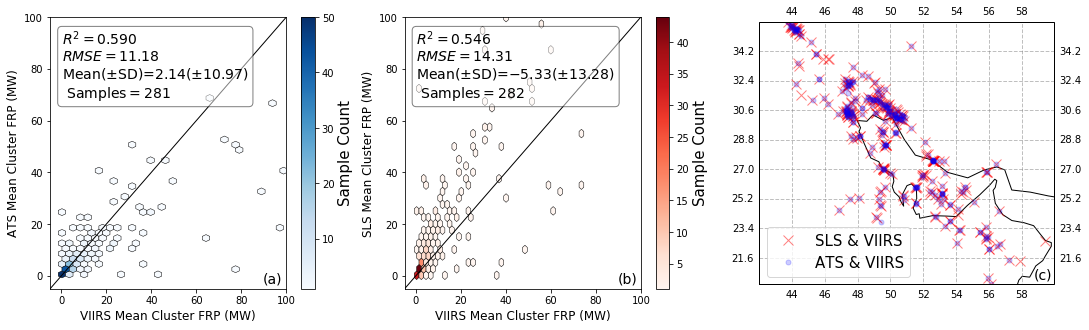

In [93]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

plt.close('all')
fig = plt.figure(figsize=(18, 5))
ax0 = plt.subplot(131)
ax1 = plt.subplot(132)
ax2 = plt.subplot(133, projection=ccrs.PlateCarree())

h = ax0.hexbin(ats_vs_viirs.frp_viirs, ats_vs_viirs.frp_ats, gridsize=30, mincnt=1,
          cmap='Blues', linewidths=0.5, edgecolors='k')
cbar = plt.colorbar(mappable=h, ax=ax0).set_label('Sample Count', fontsize=15)

h = ax1.hexbin(sls_vs_viirs.frp_viirs, sls_vs_viirs.frp_sls, gridsize=35, mincnt=1,
          cmap='Reds', linewidths=0.5, edgecolors='k')
cbar = plt.colorbar(mappable=h, ax=ax1).set_label('Sample Count', fontsize=15)

# sns.regplot(ats_vs_viirs.frp_viirs, ats_vs_viirs.frp_ats, ci=95, color='k', ax=ax0, scatter=False)
# sns.regplot(sls_vs_viirs.frp_viirs, sls_vs_viirs.frp_sls, ci=95, color='k', ax=ax1, scatter=False)

ax0.text(0.90, 0.02, '(a)', transform=ax0.transAxes, fontsize=14)
ax1.text(0.90, 0.02, '(b)', transform=ax1.transAxes, fontsize=14)
ax2.text(0.93, 0.02, '(c)', transform=ax2.transAxes, fontsize=14)


x_lim = (-5,100)
y_lim = (-5,100)
ax0.plot(x_lim, y_lim, color='k', linestyle='-', linewidth=1)
ax1.plot(x_lim, y_lim, color='k', linestyle='-', linewidth=1)

ax0.set_xlim(x_lim)
ax1.set_xlim(x_lim)

ax0.set_ylim(y_lim)
ax1.set_ylim(y_lim)

ax0.set(ylabel='ATS Mean Cluster FRP (MW)', xlabel='VIIRS Mean Cluster FRP (MW)')
ax0.yaxis.label.set_size(12)
ax0.xaxis.label.set_size(12)

ax1.set(ylabel='SLS Mean Cluster FRP (MW)', xlabel='VIIRS Mean Cluster FRP (MW)')
ax1.yaxis.label.set_size(12)
ax1.xaxis.label.set_size(12)

slope0, intercept0, r_value0, _, _ = scipy.stats.linregress(ats_vs_viirs.frp_viirs, 
                                                            ats_vs_viirs.frp_ats)
slope1, intercept1, r_value1, _, _ = scipy.stats.linregress(sls_vs_viirs.frp_viirs, 
                                                            sls_vs_viirs.frp_sls)

ats_rmse = rmse(ats_vs_viirs.frp_ats, ats_vs_viirs.frp_viirs)
sls_rmse = rmse(sls_vs_viirs.frp_sls, sls_vs_viirs.frp_viirs)

ats_mean = np.mean(ats_vs_viirs.frp_viirs - ats_vs_viirs.frp_ats)
sls_mean = np.mean(sls_vs_viirs.frp_viirs - sls_vs_viirs.frp_sls)

ats_sd = np.std(ats_vs_viirs.frp_viirs - ats_vs_viirs.frp_ats)
sls_sd = np.std(sls_vs_viirs.frp_viirs - sls_vs_viirs.frp_sls)

textstr0 = '$R^2=%.3f$\n$RMSE=%.2f$\nMean($\pm$SD)=$%.2f(\pm%.2f)$\n Samples$=%.0f$' % (r_value0**2, ats_rmse, ats_mean, ats_sd, ats_vs_viirs.frp_viirs.shape[0])
textstr1 = '$R^2=%.3f$\n$RMSE=%.2f$\nMean($\pm$SD)=$%.2f(\pm%.2f)$\n Samples$=%.0f$' % (r_value1**2, sls_rmse, sls_mean, sls_sd, sls_vs_viirs.frp_viirs.shape[0]) 

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax0.text(0.05, 0.95, textstr0, transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax1.text(0.05, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# do sampling map
# xlims = [(-180, 180), (-105, -87), (4, 9), (46, 56), (65, 82), (106, 125)]
#     ylims = [(-90, 90), (25, 39), (3, 7), (23, 33), (55, 68), (33, 45)]
#     pos = [(-102, 40), (-2, -1), (39, 26), (83, 62), (113, 47)]
ax2.set_xlim((min_lon, max_lon))
ax2.set_ylim((min_lat, max_lat))
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.plot(sls_vs_viirs.lons, sls_vs_viirs.lats, 'rx', alpha=0.5, markersize=10, label='SLS & VIIRS')
ax2.plot(ats_vs_viirs.lons, ats_vs_viirs.lats, 'b.', alpha=0.2, markersize=10, label='ATS & VIIRS')
ax2.legend(prop={'size': 15})
plt.savefig(os.path.join(output_path, 'viirs_vs_ats_iraq.png'), bbox_inches='tight', dpi=600)
plt.show()

# ------- COUNTRY LEVEL ANALYSES -------

# ANNUAL TIMESERIES: ANNUAL ACTIVE FLARES
Ratio of the number of flares seen active in any given country over a 12 month period to all flares seen active in the given country over the entire timeseries (both ATS and SLS.

In [68]:
def counts_by_country(ats_flare_df, sls_flare_df, ats_countries_df, sls_countries_df):
    
    flare_df = pd.concat([ats_flare_df, sls_flare_df])
    countries_df = pd.concat([ats_countries_df, sls_countries_df])
    
    # rename years where we have data from both sensors (1996 AT1 & AT2; 2002 AT2 & ATS )    
    flare_df.sensor.loc[flare_df.year == 1996] = 'AT1 & AT2'
    flare_df.sensor.loc[flare_df.year == 2002] = 'AT2 & ATS'
    
    # get unique countries
    countries_df.drop_duplicates(['countries', 'lats_arcmin', 'lons_arcmin'], inplace=True)
    
    # get unique annual flares
    annual_unique_flares = flare_df.drop_duplicates(['lats_arcmin', 'lons_arcmin', 'year'])[['lats_arcmin', 'lons_arcmin', 'year']]    
    annual_unique_flares_by_sensor = flare_df.drop_duplicates(['lats_arcmin', 'lons_arcmin', 'year', 'sensor'])[['lats_arcmin', 'lons_arcmin', 'year', 'sensor']]
        
    # merge countries
    annual_unique_flares = annual_unique_flares.merge(countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])
    annual_unique_flares_by_sensor = annual_unique_flares_by_sensor.merge(countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])

    
    # add active flares and flare locations columns
    annual_unique_flares['active_flare_locations'] = 1
    annual_unique_flares_by_sensor['active_flare_locations'] = 1
    
    # now group 
    grouped_annual_unique_flares = annual_unique_flares.groupby(['year', 'countries'], as_index=False).agg(
        {'active_flare_locations': np.sum})
    grouped_annual_unique_flares_by_sensor = annual_unique_flares_by_sensor.groupby(['year', 'countries', 'sensor'], as_index=False).agg(
        {'active_flare_locations': np.sum})
    
    # divide by 1000 (to get counts in 000s)
    grouped_annual_unique_flares['active_flare_locations'] = grouped_annual_unique_flares.active_flare_locations /1000
    grouped_annual_unique_flares_by_sensor['active_flare_locations'] = grouped_annual_unique_flares_by_sensor.active_flare_locations /1000
    

    return grouped_annual_unique_flares, grouped_annual_unique_flares_by_sensor
    

In [69]:
annual_flare_activity_df, annual_flare_activity_by_sensor_df = counts_by_country(ats_flare_df, 
                                                                                 sls_flare_df, 
                                                                                 ats_countries_df, 
                                                                                 sls_countries_df)


In [70]:
for yr in [2016, 1991, 2012, 2018]:
    annual_flare_activity_by_sensor_df = annual_flare_activity_by_sensor_df[annual_flare_activity_by_sensor_df.year != yr]

# get the global annual FRP values
global_activity = annual_flare_activity_by_sensor_df.groupby(['sensor', 'year'], as_index=False).agg({'active_flare_locations': np.sum})
global_activity = global_activity.pivot('year', 'sensor', 'active_flare_locations')
global_activity.columns.name = None
global_activity.rename(columns={'at1': 'AT1', 'at2':'AT2', 'ats':'ATS', 'sls':'SLS'}, inplace=True)
global_activity = global_activity[['AT1', 'AT1 & AT2', 'AT2', 'AT2 & ATS', 'ATS', 'SLS']]

to_group = ['countries', 'year']
to_agg = {'active_flare_locations': np.sum}
screened_countries_activity_df = annual_flare_activity_by_sensor_df.groupby(to_group, as_index=False).agg(to_agg)

# # find the top n flaring countries
n_countries = 30
top_flaring_countries = screened_countries_activity_df.groupby('countries').agg({'active_flare_locations': np.sum}).sort_values('active_flare_locations', ascending=False).head(n_countries).reset_index()

# # reduce to the top countries
top_country_activity = screened_countries_activity_df.merge(top_flaring_countries[['countries']],  on=['countries'])

# pivoted
pivoted_df = top_country_activity.pivot('year', 'countries', 'active_flare_locations')
df_list = []
for c in top_flaring_countries.countries.values:
    df_list.append(pivoted_df[c])
top_country_activity = pd.concat(df_list, axis=1)

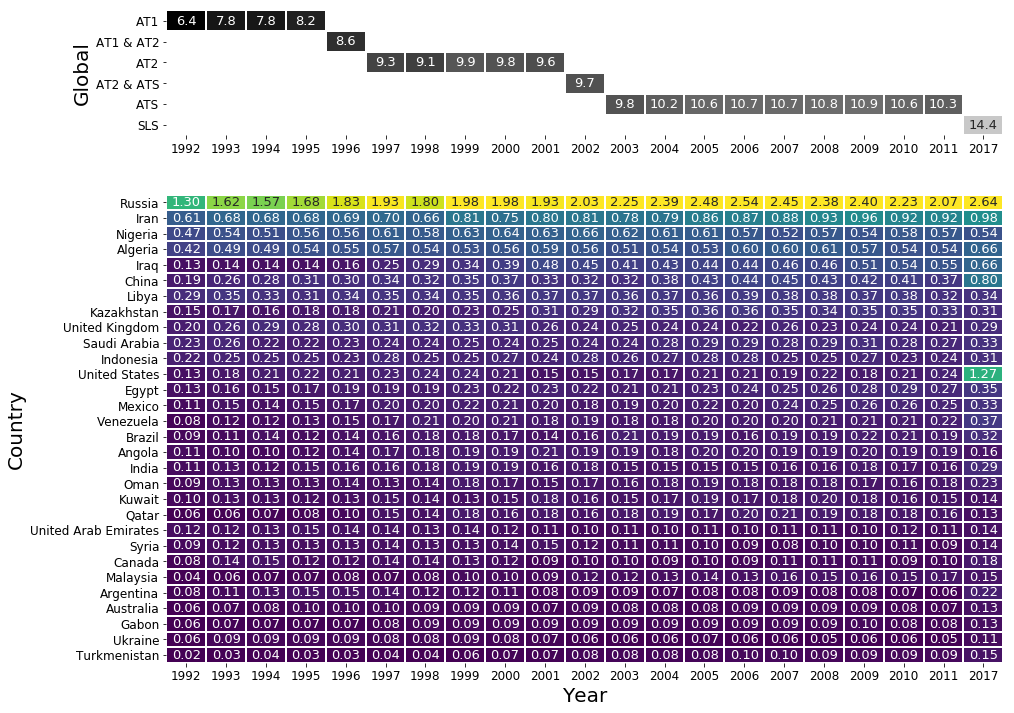

In [71]:
plt.close('all')
#fig, ax = plt.figure(figsize=(18,7))

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, 
                               gridspec_kw={'height_ratios': [2, 7.5]},
                               figsize=(15, 12))

sns.heatmap(global_activity.T, linewidths=1,
            robust=True, annot=True, 
            annot_kws={'fontsize':13},
            fmt='.1f',
            cbar=False,
            cmap='Greys_r',
            vmax=18,
            ax=ax0)

ax0.set(xlabel='', ylabel='Global')
ax0.yaxis.label.set_size(20)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=12)
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=12, rotation=0)

sns.heatmap(top_country_activity.T, linewidths=1,
            robust=True, annot=True, 
            annot_kws={'fontsize':13}, 
            fmt='.2f',
            cbar=False,
            cmap='viridis',
            ax=ax1)
ax1.set(xlabel='Year', ylabel='Country')
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
plt.savefig(os.path.join(output_path, 'ats_counts.png'), bbox_inches='tight', dpi=600)

plt.show()

Figure Comments: The global figure shows all counts for all sensors (exlcuding 2016 data for SLS as no flare observations).  The country level analysis uses only the valid non-overlapping years (which are defined in the code), so: AT2 1995; AT1 1996; ATS 2002; & AT2 2003 are not used).  This needs to be done, as the geospatial alginment is not exact and we cannot be certain on the total counts if we combine sensors (i.e. perhaps double counting some flares).

### Percent Change

In [72]:
activity_global_pc_change = annual_flare_activity_by_sensor_df.groupby(['sensor', 'year'], as_index=False).agg({'active_flare_locations': np.sum})
activity_global_pc_change = activity_global_pc_change.sort_values('year')
activity_global_pc_change['pc_change'] = (activity_global_pc_change.active_flare_locations / activity_global_pc_change.active_flare_locations.shift() - 1) 
activity_global_pc_change.drop('active_flare_locations', axis=1, inplace=True)
activity_global_pc_change = activity_global_pc_change.pivot('year', 'sensor', 'pc_change')
activity_global_pc_change.rename(columns={'at1': 'AT1', 'at2':'AT2', 'ats':'ATS', 'sls':'SLS'}, inplace=True)
activity_global_pc_change = activity_global_pc_change[['AT1', 'AT1 & AT2', 'AT2', 'AT2 & ATS', 'ATS', 'SLS']]


activity_country_pc_change = top_country_activity.copy()
activity_country_pc_change = (activity_country_pc_change / activity_country_pc_change.shift() - 1) 

for yr in [1992]:
    activity_global_pc_change = activity_global_pc_change[activity_global_pc_change.index != yr]
    activity_country_pc_change = activity_country_pc_change[activity_country_pc_change.index != yr]

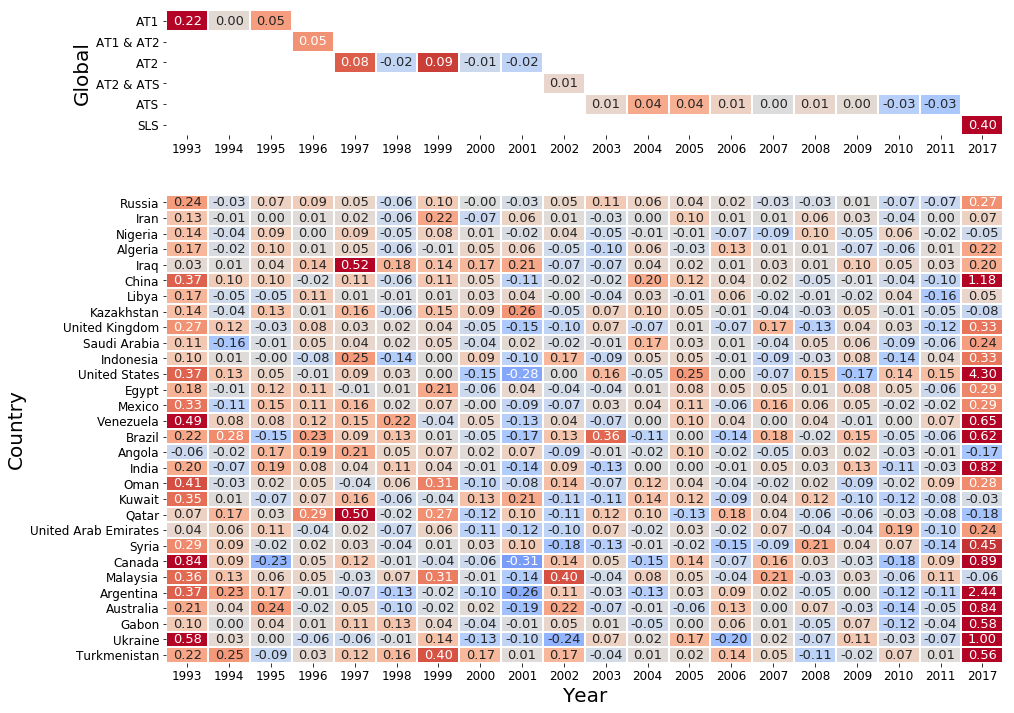

In [73]:
plt.close('all')
#fig, ax = plt.figure(figsize=(18,7))

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, 
                               gridspec_kw={'height_ratios': [2, 7.5]},
                               figsize=(15, 12))

sns.heatmap(activity_global_pc_change.T, linewidths=1,
            robust=True, annot=True, 
            fmt='.2f', annot_kws={'fontsize':13}, 
            cbar=False,
            cmap='coolwarm',
            vmax=0.1, vmin=-0.1,
            ax=ax0)

ax0.set(xlabel='', ylabel='Global')
ax0.yaxis.label.set_size(20)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=12)
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=12, rotation=0)


sns.heatmap(activity_country_pc_change.T, linewidths=1,
            robust=True, annot=True, 
            fmt='.2f', annot_kws={'fontsize':13}, 
            cbar=False,
            cmap='coolwarm',
            vmax=0.5, vmin=-0.5,
            ax=ax1)
ax1.set(xlabel='Year', ylabel='Country')
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)

plt.savefig(os.path.join(output_path, 'ats_counts_change.png'), bbox_inches='tight', dpi=600)

plt.show()

# COMPUTE ANNUAL MEAN CLOUD ADJUSTED FRP PER COUNTRY
First group each arcminute grid cell for each year in the flare dataframe, aggregating the fire radiative power and the total number of observations in that year by summing.  Do the same for the sampling dataframe (i.e. the number of overpass for a given flare).

The cloud adjusted mean is computed as the sum of the hotspot's FRP for the year divided by the total number of overpasses for the hotspot adjusted for cloud cover e.g. 6000 [MW] / ( 120 [Obs.] * (1 - 0.6 [CC]).  So we in effect get the mean FRP based on some assumption of number of cloud free observations (this also normalises for variance in observation).  The cloud cover I estimate from an 8 by 8 window around each hotspot, from which I take the ATSR cloud flag.  This is then averaged for the year, so I get an annual mean cloud cover estimate for each hotspot.

what happens if the "hotspot" is observed to be not there? i.e. a location previously seen to be a flare is cloud free - but now there is nothing there (i.e. flare is turned off for a while...maybe it is re-detected in a few weeks or months?).  Do these "zero" FRP values contribute to the "mean FRP" or not?  it seems not from your calculation.  if they do not then multippying the cloud-adjusted Mean FRP by the number of secs in a year will not i think come up with "correct FRE" will it? Because you are then counting the thing has burning at its "mean FRP" value even when it has been observed as not burning? When there has been a cloud free observation of the flares location and it is confirmed that there is "nothing there" then that time period should not contribute to the FRE calculation..or...the "mean FRE" should include the value of "zero FRP" observed for that observation. 

The number of observations includes not only active flaring, but all overpasses of the flaring location during the year.  So in the above example the 6000MW could be calculated from 50 of the 120 overpasses, but all 120 (including the 70 'zero' observations) are used for the mean (although this number is further adjusted for cloud cover).  So it does take into account the issue of flare persistence. 

Two difference dataframe are created.  One with sensor information and one without.  The one without sensor information effectively creates a mean value for any overlapping years.  This is unwanted, but useful in any analysis.  The one with sensor information allows screening of year/sensor combinations so that we don't get any overlapping information contaminating the results. 

In [74]:
def frp_by_country(flare_df, sampling_df, countries_df):
    
    # compute the annual mean for each flare
    to_group = ['lats_arcmin', 'lons_arcmin', 'year']
    to_agg = {'frp': np.sum,
              'sample_counts_flare': np.sum,
              'lats': np.mean,
              'lons': np.mean}
    annual_summed_flare_df = flare_df.groupby(to_group, as_index=False).agg(to_agg)

    # get the cloud cover adjusted sampling
    to_group = ['lats_arcmin', 'lons_arcmin', 'year']
    to_agg = {'cloud_cover': np.mean,
              'sample_counts_all': np.sum}
    annual_sample_df = sampling_df.groupby(to_group, as_index=False).agg(to_agg)
    
    # merge and get cloud cloud adjusted sampling (i.e the expected number of observations)
    annual_frp_df = pd.merge(annual_summed_flare_df, annual_sample_df, on=to_group)
    annual_frp_df['cloud_adjusted_sample_counts'] = annual_frp_df.sample_counts_all * (1-annual_frp_df.cloud_cover)

    # if expected less than actual, then set to actual number of obsercations
    mask = annual_frp_df['cloud_adjusted_sample_counts'] < annual_frp_df['sample_counts_flare']
    annual_frp_df.loc[mask, 'cloud_adjusted_sample_counts'] = annual_frp_df.loc[mask, 'sample_counts_flare']

    # compute mean frp
    annual_frp_df['cloud_adjusted_mean_frp'] = annual_frp_df.frp / annual_frp_df.cloud_adjusted_sample_counts

    # merge countries
    annual_frp_df = annual_frp_df.merge(countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])

    # sum on a per country basis
    grouped_annual_frp = annual_frp_df.groupby(['year', 'countries'], as_index=False).agg({'cloud_adjusted_mean_frp': np.sum})

    # ---------------------------------------
    # Same again but with sensor information
    # ---------------------------------------
    
    # rename years where we have data from both sensors (1996 AT1 & AT2; 2002 AT2 & ATS )    
    flare_df.sensor.loc[flare_df.year == 1996] = 'AT1 & AT2'
    flare_df.sensor.loc[flare_df.year == 2002] = 'AT2 & ATS'
    sampling_df.sensor.loc[sampling_df.year == 1996] = 'AT1 & AT2'
    sampling_df.sensor.loc[sampling_df.year == 2002] = 'AT2 & ATS'
    
    # compute the annual mean for each flare
    to_group = ['lats_arcmin', 'lons_arcmin', 'year', 'sensor']
    to_agg = {'frp': np.sum,
              'sample_counts_flare': np.sum,
              'lats': np.mean,
              'lons': np.mean}
    annual_summed_flare_df = flare_df.groupby(to_group, as_index=False).agg(to_agg)
    
    # get the cloud cover adjusted sampling
    to_group = ['lats_arcmin', 'lons_arcmin', 'year', 'sensor']
    to_agg = {'cloud_cover': np.mean,
              'sample_counts_all': np.sum}
    annual_sample_df = sampling_df.groupby(to_group, as_index=False).agg(to_agg)
    
    # merge and get cloud cloud adjusted sampling (i.e the expected number of observations)
    annual_frp_df = pd.merge(annual_summed_flare_df, annual_sample_df, on=to_group)
    annual_frp_df['cloud_adjusted_sample_counts'] = annual_frp_df.sample_counts_all * (1-annual_frp_df.cloud_cover)

    # if expected less than actual, then set to actual number of obsercations
    mask = annual_frp_df['cloud_adjusted_sample_counts'] < annual_frp_df['sample_counts_flare']
    annual_frp_df.loc[mask, 'cloud_adjusted_sample_counts'] = annual_frp_df.loc[mask, 'sample_counts_flare']

    # compute mean frp
    annual_frp_df['cloud_adjusted_mean_frp'] = annual_frp_df.frp / annual_frp_df.cloud_adjusted_sample_counts

    # merge countries
    annual_frp_df = annual_frp_df.merge(countries_df[['countries', 'lats_arcmin', 'lons_arcmin']],  on=['lats_arcmin', 'lons_arcmin'])

    # sum on a per country basis
    grouped_annual_frp_by_sensor = annual_frp_df.groupby(['year', 'countries', 'sensor'], as_index=False).agg({'cloud_adjusted_mean_frp': np.sum})
    
    return grouped_annual_frp, grouped_annual_frp_by_sensor

In [75]:
ats_annual_frp_by_country, ats_annual_frp_by_country_with_sensor = frp_by_country(ats_flare_df, 
                                                                                  ats_flare_sampling_df, 
                                                                                  ats_countries_df)
sls_annual_frp_by_country, sls_annual_frp_by_country_wtih_sensor = frp_by_country(sls_flare_df, 
                                                                                  sls_flare_sampling_df,
                                                                                  sls_countries_df)


In [76]:
ats_annual_frp_by_country_with_sensor.sensor.unique()

array(['at1', 'AT1 & AT2', 'at2', 'AT2 & ATS', 'ats'], dtype=object)

# DMSP ANNUAL NATIONAL FLARED VOLUME COMPARISON WITH ATSR

In [77]:
df_with_bcm = ats_annual_frp_by_country_with_sensor.copy()

df_with_bcm = ats_annual_frp_by_country.merge(bcm_df, on=['countries', 'year'])
df_with_bcm.dropna(inplace=True)

# get rid of end years
df_with_bcm = df_with_bcm[df_with_bcm.year != 2012]
df_with_bcm = df_with_bcm[df_with_bcm.year != 1991]

# russia and nigeria
df_with_bcm_rn = df_with_bcm.copy()
df_with_bcm_rn = df_with_bcm_rn[(df_with_bcm_rn.countries == 'Russia') | 
                                (df_with_bcm_rn.countries == 'Nigeria')]

# all other countires
df_with_bcm_not_rn = df_with_bcm.copy()
df_with_bcm_not_rn = df_with_bcm_not_rn[(df_with_bcm_not_rn.countries != 'Russia') & 
                                (df_with_bcm_not_rn.countries != 'Nigeria')]


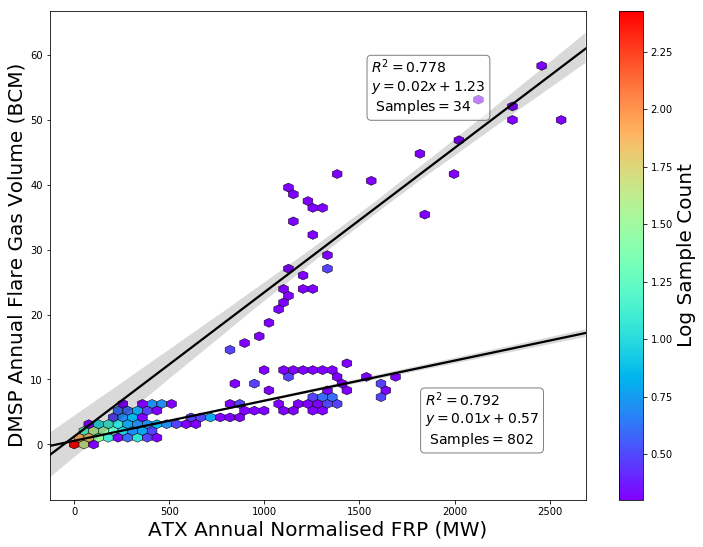

In [78]:
plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9))

h = ax.hexbin(df_with_bcm.cloud_adjusted_mean_frp, df_with_bcm.bcm, gridsize=50, bins='log', mincnt=1,
          cmap='rainbow', linewidths=0.5, edgecolors='k')
cbar = plt.colorbar(mappable=h).set_label('Log Sample Count', fontsize=20)

sns.regplot(df_with_bcm_rn.cloud_adjusted_mean_frp, df_with_bcm_rn.bcm, ci=68, color='k', ax=ax, scatter=False)
sns.regplot(df_with_bcm_not_rn.cloud_adjusted_mean_frp, df_with_bcm_not_rn.bcm, ci=68, color='k', ax=ax, scatter=False)

ax.set(ylabel='DMSP Annual Flare Gas Volume (BCM)', xlabel='ATX Annual Normalised FRP (MW)')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

slope0, intercept0, r_value0, _, _ = scipy.stats.linregress(df_with_bcm_rn.cloud_adjusted_mean_frp, 
                                                            df_with_bcm_rn.bcm)
slope1, intercept1, r_value1, _, _ = scipy.stats.linregress(df_with_bcm_not_rn.cloud_adjusted_mean_frp, 
                                                            df_with_bcm_not_rn.bcm)


textstr0 = '$R^2=%.3f$\n$y=%.2fx + %.2f$\n Samples$=%.0f$' % (r_value0**2, slope0, intercept0, df_with_bcm_rn.bcm.shape[0])
textstr1 = '$R^2=%.3f$\n$y=%.2fx + %.2f$\n Samples$=%.0f$' % (r_value1**2, slope1, intercept1, df_with_bcm_not_rn.bcm.shape[0]) 

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

ax.text(0.6, 0.9, textstr0, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.text(0.7, 0.22, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.savefig(os.path.join(output_path, 'dmsp_vs_ats.png'), bbox_inches='tight', dpi=600)

plt.show()

# ANNUAL TIMESERIES: COUNTRY LEVEL SUMMED MEAN FLARE FRP 
Each flare has its annual mean computed and then all flares for a given nation are summed together for the year

In [79]:
# reduce the data to only complete years
ats_with_sensor_df = ats_annual_frp_by_country_with_sensor.copy()
sls_with_sensor_df = sls_annual_frp_by_country_wtih_sensor.copy()

for yr in [1991, 2012, 2016, 2018]:
    ats_with_sensor_df = ats_with_sensor_df[ats_with_sensor_df.year != yr]
    sls_with_sensor_df = sls_with_sensor_df[sls_with_sensor_df.year != yr]

# combine the dataframes
combined_with_sensor_df = pd.concat([ats_with_sensor_df, sls_with_sensor_df])
    
# get the global annual FRP values
global_frp = combined_with_sensor_df.groupby(['sensor', 'year'], as_index=False).agg({'cloud_adjusted_mean_frp': np.sum})
global_frp.cloud_adjusted_mean_frp /= 1000
global_frp = global_frp.pivot('year', 'sensor', 'cloud_adjusted_mean_frp')
global_frp.columns.name = None
global_frp.rename(columns={'at1': 'AT1', 'at2':'AT2', 'ats':'ATS', 'sls':'SLS'}, inplace=True)
global_frp = global_frp[['AT1', 'AT1 & AT2', 'AT2', 'AT2 & ATS', 'ATS', 'SLS']]
    
# now aggregate to remove sensor information from screened data 
to_group = ['countries', 'year']
to_agg = {'cloud_adjusted_mean_frp': np.sum}
combined_df = combined_with_sensor_df.groupby(to_group, as_index=False).agg(to_agg)
combined_df.cloud_adjusted_mean_frp /= 1000

# # find the top n flaring countries
n_countries = 30
top_flaring_countries = combined_df.groupby('countries').agg({'cloud_adjusted_mean_frp': np.sum}).sort_values('cloud_adjusted_mean_frp', ascending=False).head(n_countries).reset_index()

# # reduce to the top countries
top_flaring_activity = combined_df.merge(top_flaring_countries[['countries']],  on=['countries'])

# pivoted
pivoted_df = top_flaring_activity.pivot('year', 'countries', 'cloud_adjusted_mean_frp')
df_list = []
for c in top_flaring_countries.countries.values:
    df_list.append(pivoted_df[c])
top_flaring_activity = pd.concat(df_list, axis=1)

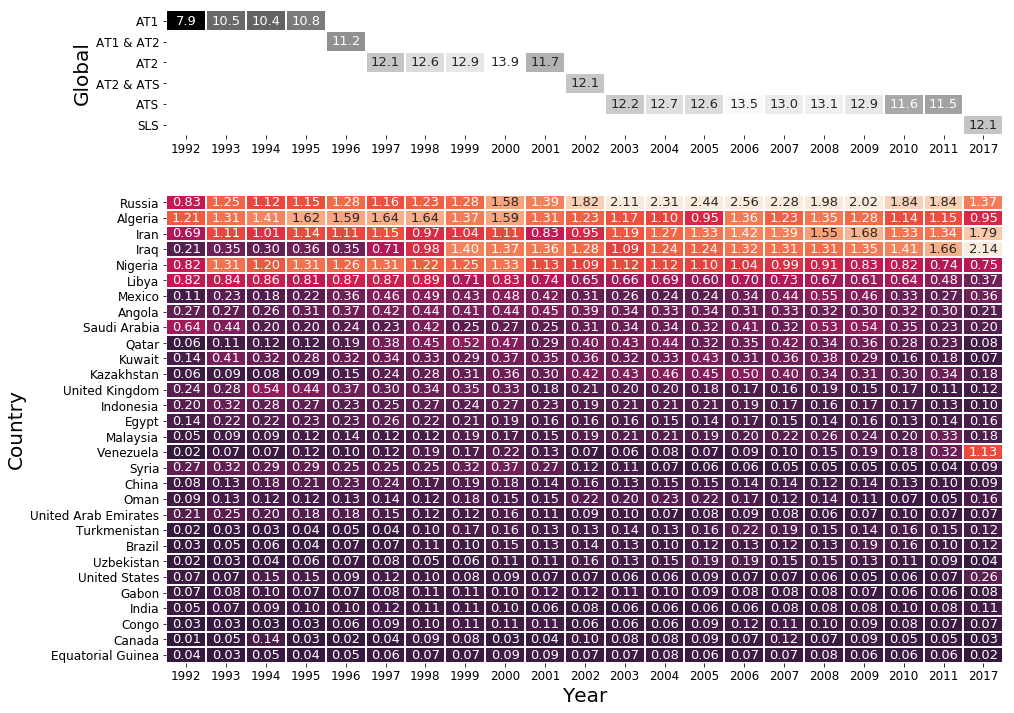

In [80]:
plt.close('all')
#fig, ax = plt.figure(figsize=(18,7))

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, 
                               gridspec_kw={'height_ratios': [2, 7.5]},
                               figsize=(15, 12))

sns.heatmap(global_frp.T, linewidths=1,
            robust=True, annot=True, 
            fmt='.1f', annot_kws={'fontsize':13}, 
            cbar=False,
            cmap='Greys_r',
            ax=ax0)

ax0.set(xlabel='', ylabel='Global')
ax0.yaxis.label.set_size(20)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=12)
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=12, rotation=0)


sns.heatmap(top_flaring_activity.T, linewidths=1,
            robust=True, annot=True, 
            fmt='.2f', annot_kws={'fontsize':13}, 
            cbar=False,
            vmin=-0.3, vmax=2,
            ax=ax1)
ax1.set(xlabel='Year', ylabel='Country')
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
plt.savefig(os.path.join(output_path, 'ats_frp.png'), bbox_inches='tight', dpi=600)

plt.show()

### Percent Change

In [81]:
frp_global_pc_change = combined_with_sensor_df.groupby(['sensor', 'year'], as_index=False).agg({'cloud_adjusted_mean_frp': np.sum})
frp_global_pc_change = frp_global_pc_change.sort_values('year')
frp_global_pc_change['pc_change'] = (frp_global_pc_change.cloud_adjusted_mean_frp / frp_global_pc_change.cloud_adjusted_mean_frp.shift() - 1) 
frp_global_pc_change.drop('cloud_adjusted_mean_frp', axis=1, inplace=True)
frp_global_pc_change = frp_global_pc_change.pivot('year', 'sensor', 'pc_change')
frp_global_pc_change.rename(columns={'at1': 'AT1', 'at2':'AT2', 'ats':'ATS', 'sls':'SLS'}, inplace=True)
frp_global_pc_change = frp_global_pc_change[['AT1', 'AT1 & AT2', 'AT2', 'AT2 & ATS', 'ATS', 'SLS']]


frp_country_pc_change = (top_flaring_activity / top_flaring_activity.shift() - 1) 
for yr in [1992]:
    frp_global_pc_change = frp_global_pc_change[frp_global_pc_change.index != yr]
    frp_country_pc_change = frp_country_pc_change[frp_country_pc_change.index != yr]

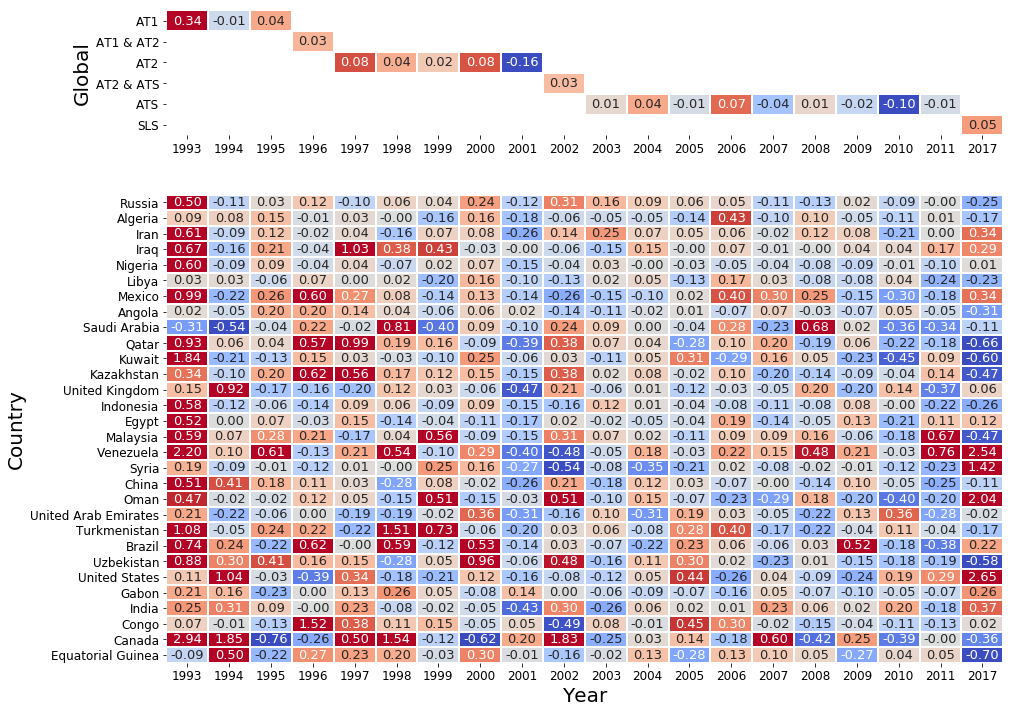

In [82]:
plt.close('all')
#fig, ax = plt.figure(figsize=(18,7))

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, 
                               gridspec_kw={'height_ratios': [2, 7.5]},
                               figsize=(15, 12))

sns.heatmap(frp_global_pc_change.T, linewidths=1,
            robust=True, annot=True, 
            fmt='.2f', annot_kws={'fontsize':13}, 
            cbar=False,
            cmap='coolwarm',
            vmax=0.1, vmin=-0.1,
            ax=ax0)

ax0.set(xlabel='', ylabel='Global')
ax0.yaxis.label.set_size(20)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize=12)
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize=12, rotation=0)


sns.heatmap(frp_country_pc_change.T, linewidths=1,
            robust=True, annot=True, 
            fmt='.2f', annot_kws={'fontsize':13}, 
            cbar=False,
            cmap='coolwarm',
            vmax=0.5, vmin=-0.5,
            ax=ax1)
ax1.set(xlabel='Year', ylabel='Country')
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)
plt.savefig(os.path.join(output_path, 'ats_frp_change.png'), bbox_inches='tight', dpi=600)

plt.show()

# Total Flare Emission Map

This map shows each flares emissions over the entire ATSR timeseries.  We use the screened data (from the screening process above) and the FRP is the cloud adjusted values.  So it takes into account the persistency and typical cloud cover of the flare when computing the average.

This is currently showing the mean over the lifetime.  Change it to back to mean over year, multiply by time in year, then group over years to get flare activity.

In [83]:
def myround(x, base=0.5):
    return base * np.round(x/base)

def plot_total_frp(frp, binned_stat, top_flares):
    plt.close('all')
    fig = plt.figure(figsize=(20,9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xlim(( -180, 180))
    ax.set_ylim((-90, 90))
    ax.coastlines(color='white', linewidth=0.75)
    
    img_extent = (-180, 180, -90, 90)
    ax.imshow(np.tile(np.array([[[0,0,0]]], 
          dtype=np.uint8), [2, 2, 1]),
      origin='upper',
      transform=ccrs.PlateCarree(),
      extent=img_extent)
    


    #ax.text(0.94, 0.92, lab, transform=ax.transAxes, fontsize=25, color='w')
    
    
    scat = ax.scatter(frp_df.lons, frp_df.lats,
              s=0.05,
              color='cyan',
              alpha=0.2,
              label='Flare Locations') 
    
    scat2 = ax.scatter(top_flares.lons, top_flares.lats,
                       s=55,
                       facecolor='chartreuse',
                       edgecolor='k',
                       alpha=1,
                       label='10% Flare Locations')   
    
    leg0 = ax.legend(loc = 3, scatterpoints = 1, prop={'size': 15,})
    leg0.get_frame().set_facecolor('k')
    leg0.legendHandles[0]._sizes = [40]
    leg0.legendHandles[0].set_alpha(1)
    
    leg0.legendHandles[1]._sizes = [110]
    leg0.legendHandles[1].set_alpha(1)
    
    plt.setp(leg0.get_texts(), color='w')

    im = ax.imshow(binned_stat, origin='upper', cmap='inferno', norm=LogNorm(vmin=10, vmax=10000), alpha=1,
              extent=img_extent, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(mappable=im).set_label('Log FRP (MW)', fontsize=20)
    

    #-------------------
    # SUBPLOTS
    #-------------------
    
    # set up the subaxes and locations
    sub_x_extent = [(46, 53), (5,25), (4.5, 13.5)]
    sub_y_extent = [(25, 33), (27,33), (-9, 7)]
    rects = [[0.43, 0.2, 0.3, 0.25], [0.27, 0.68, 0.15, 0.2], [-0.12, 0.27, 0.6, 0.4]]
    locs = [(1,2), (3,4), (1,4)]

    # add in zoomed plots for rois
    for sub_x, sub_y, rect, loc in zip(sub_x_extent, sub_y_extent, rects, locs):
    
        sub_ax = fig.add_axes(rect,
                              projection=ccrs.PlateCarree(), )
        sub_ax.set_xlim(sub_x)
        sub_ax.set_ylim(sub_y)
        sub_ax.outline_patch.set_edgecolor('white')

        # show inset loc
        mark_inset(ax, sub_ax, loc1=loc[0], loc2=loc[1], fc="none", lw=1, ec='w')

        # add background
        #sub_ax.coastlines(color='white', linewidth=0.75)
        country_boundaries = feature.NaturalEarthFeature(category='cultural',
                                                name='admin_0_countries',
                                                scale='10m', facecolor='none')
        sub_ax.add_feature(country_boundaries, edgecolor='white')
        sub_ax.imshow(np.tile(np.array([[[0,0,0]]], 
              dtype=np.uint8), [2, 2, 1]),
          origin='upper',
          transform=ccrs.PlateCarree(),
          extent=sub_x + sub_y)

        sub_scat = sub_ax.scatter(frp_df.lons, frp_df.lats,
              s=0.05,
              color='cyan',
              alpha=0.2) 

        sub_scat2 = sub_ax.scatter(top_flares.lons, top_flares.lats,
                           s=55,
                           facecolor='chartreuse',
                           edgecolor='k',
                           alpha=1) 
    plt.savefig(os.path.join(output_path, 'flare_map.png'), bbox_inches='tight', dpi=600)
    plt.show()
                  

In [84]:
# compute the annual mean for each flare
to_group = ['lats_arcmin', 'lons_arcmin', 'year']
to_agg = {'frp': np.sum,
          'sample_counts_flare': np.sum,
          'lats': np.mean,
          'lons': np.mean}
summed_flare_df = ats_flare_df.groupby(to_group, as_index=False).agg(to_agg)

# get the cloud cover adjusted sampling
to_group = ['lats_arcmin', 'lons_arcmin', 'year']
to_agg = {'cloud_cover': np.mean,
          'sample_counts_all': np.sum}
summed_sample_df = ats_flare_sampling_df.groupby(to_group, as_index=False).agg(to_agg)

# merge and get cloud cloud adjusted sampling (i.e the expected number of observations)
frp_df = pd.merge(summed_flare_df, summed_sample_df, on=to_group)
frp_df['cloud_adjusted_sample_counts'] = frp_df.sample_counts_all * (1-frp_df.cloud_cover)

# if expected less than actual, then set to actual number of obsercations
mask = frp_df['cloud_adjusted_sample_counts'] < frp_df['sample_counts_flare']
frp_df.loc[mask, 'cloud_adjusted_sample_counts'] = frp_df.loc[mask, 'sample_counts_flare']

# compute mean frp
frp_df['cloud_adjusted_mean_frp'] = frp_df.frp / frp_df.cloud_adjusted_sample_counts

# get yearly sums
to_group = ['lats_arcmin', 'lons_arcmin']
to_agg = {'cloud_adjusted_mean_frp': np.sum, 'lats': np.mean, 'lons': np.mean}
annual_grouped_df = frp_df.groupby(to_group, as_index=False).agg(to_agg)



In [85]:
bin_x = np.arange(-180, 185, 5)
bin_y = np.arange(-90, 95, 5)
binned_data = stats.binned_statistic_2d(annual_grouped_df.lons, annual_grouped_df.lats, 
                                        annual_grouped_df.cloud_adjusted_mean_frp, 'sum',
                                        bins=[bin_x, bin_y])
binned_stat = np.ma.masked_array(binned_data.statistic, binned_data.statistic==0)

### now get top flares for plotting

In [86]:
annual_grouped_df['frp_pc_total'] =  annual_grouped_df.cloud_adjusted_mean_frp / annual_grouped_df.cloud_adjusted_mean_frp.sum()

In [87]:
sorted_annual_grouped_df = annual_grouped_df.sort_values('frp_pc_total', ascending=False)
sorted_annual_grouped_df['frp_pc_cumsum'] = sorted_annual_grouped_df.frp_pc_total.cumsum()
sorted_annual_grouped_df.reset_index(inplace=True, drop=True)

In [88]:
n_flares_10_pc = np.sum(sorted_annual_grouped_df.frp_pc_cumsum<0.1)
n_flares_50_pc = np.sum(sorted_annual_grouped_df.frp_pc_cumsum<0.5)
n_flares_90_pc = np.sum(sorted_annual_grouped_df.frp_pc_cumsum<0.9)

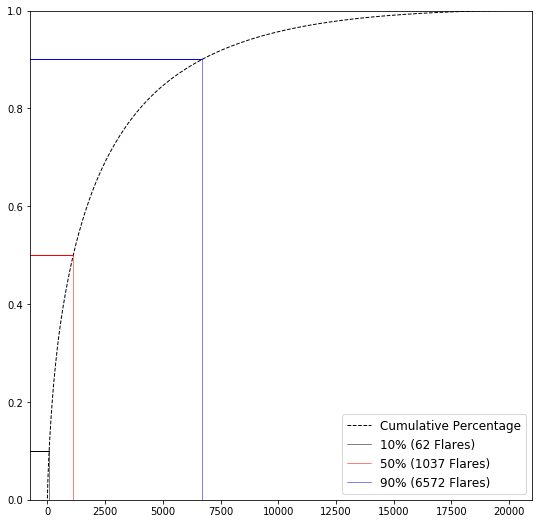

In [89]:
plt.close('all')
plt.figure(figsize=(9,9))
plt.plot(np.arange(sorted_annual_grouped_df.shape[0]), sorted_annual_grouped_df.frp_pc_total.cumsum(), 'k--',
         linewidth=1, label='Cumulative Percentage')
plt.plot([n_flares_10_pc, n_flares_10_pc], [-0.1, 0.1], 'k-', linewidth=0.5, label='10% (62 Flares)')
plt.plot([-1000, n_flares_10_pc], [0.1, 0.1], 'k-', linewidth=1)

plt.plot([n_flares_50_pc, n_flares_50_pc], [-0.1, 0.5], 'r-', linewidth=0.5, label='50% (1037 Flares)')
plt.plot([-1000, n_flares_50_pc], [0.5, 0.5], 'r-', linewidth=1)


plt.plot([n_flares_90_pc, n_flares_90_pc], [-0.1, 0.9], 'b-', linewidth=0.5, label='90% (6572 Flares)')
plt.plot([-1000, n_flares_90_pc], [0.9, 0.9], 'b-', linewidth=1)

plt.legend(loc=4,prop={'size': 12,})
plt.ylim(-0, 1)
plt.xlim(-750, 21000)
plt.savefig(os.path.join(output_path, 'ats_cumulative_frp.png'), bbox_inches='tight', dpi=600)
plt.show()

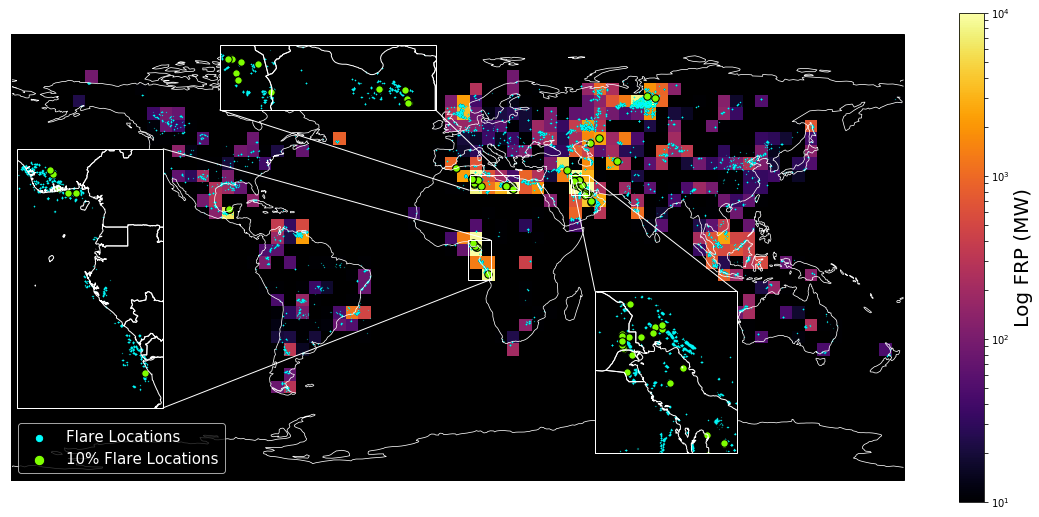

In [90]:
plot_total_frp(annual_grouped_df, np.flipud(binned_stat.T), 
               sorted_annual_grouped_df[sorted_annual_grouped_df.frp_pc_cumsum<0.1])

# ----------- NOTES -----------

Notes: 
* AT1 deficiences in Nighttime cloud masking due to only 11 & 12 um channels (so ineffective cloud masking) this means that we cannot trust the cloud adjusted FRP.  For ATSR flares, we instead use the cloud statistics for each flare from AT2 or ATS if available (with the assumption that cloud behaviour is generally consistent over any given year) 
* AT1 Data until May 1996 
* AT2 scan mirror failed  December 1995 to July 1996 (• ATSR-1 data available during this period except June 1996)
* ERS-2 Gyro failure in January 2001 (Months since gyro failure that are currently available: July to December
2001, July-August 2002, Jan-June 2003)
http://earth.esa.int/workshops/meris_aatsr2008/participants/616/pres_616_Veal.pdf

* ATSR-1	ERS-1	Jul 1991	
* ATSR-2	ERS-2	Apr 1995
* AATSR	  ENVISAT	Mar 2002	

TODO:
* Replace ATSR cloud fraction for each flare with that from ATSR-2 or AATSR
* Figure out cause of sampling differences between the three sensors (plot sampling)
* Sort out mixed years (1996: Jan-May AT1, Jul-Dec AT2; 2002: Jan-Mar AT2 Apr-Dec ATS)  DONE


https://earth.esa.int/pi/esa?topSelectedNavigationNodeId=RESULTS&colorTheme=03&type=upload&ts=1483208834953&table=result&targetIFramePage=%2Fweb%2Fguest%2Fpi-community%2Fresults&cmd=image&id=2780
See here for instrument coverage

In [ ]:
52*30